In [1]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple

# Third-party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, transpile
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display
from deap import creator, base, tools


import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms

In [2]:
BNF_GRAMMAR = grape.Grammar("testGrover.bnf")

In [3]:
def generate_oracle_for_state(marked_state: str) -> str:
    """Generate Grover oracle code for a given marked state."""
    n = len(marked_state)
    code_lines = []
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    code_lines.append(f"qc.h({n-1})")
    code_lines.append(f"qc.mcx(list(range({n-1})), {n-1})")
    code_lines.append(f"qc.h({n-1})")
    for i, bit in enumerate(marked_state):
        if bit == '0':
            code_lines.append(f"qc.x({i})")
    return "\n".join(code_lines) + "\n"

In [4]:
class CircuitEvaluator:
    def __init__(self, shots: int = 512, log_dir: str = "logs"):
        """
        Initialize the evaluator with simulation parameters and logging directory.
        """
        self.shots = shots
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
    
    def decode_individual(self, ind) -> str:
        """
        Decodes an individual's genome into a phenotype code string.
        Returns:
            A string containing the code if decoding is successful,
            or None if invalid.
        """
        if ind.invalid or not hasattr(ind, 'phenotype'):
            return None
        try:
            phenotype_code = ind.phenotype
            if isinstance(phenotype_code, list):
                phenotype_code = "".join(phenotype_code)
            # Replace literal \n with actual newlines and clean quotes
            cleaned_code = re.sub(r'\\n', '\n', phenotype_code)
            cleaned_code = re.sub(r'^"|"$', '', cleaned_code)
            cleaned_code = re.sub(r'"\s+"', '\n', cleaned_code)
            return cleaned_code
        except Exception as ex:
            print(f"[Decode Error] {ex}")
            return None
    
    def execute_circuit(self, phenotype_code: str) -> QuantumCircuit:
        """
        Executes the phenotype code to produce a QuantumCircuit.
        Returns:
            The QuantumCircuit if 'qc' is found in the execution context,
            otherwise None.
        """
        local_vars = {}
        try:
            exec(phenotype_code, globals(), local_vars)
            if "qc" in local_vars:
                return local_vars["qc"]
            else:
                print("No circuit variable 'qc' found in phenotype code.")
                return None
        except Exception as e:
            print(f"Error executing phenotype code: {e}")
            return None
    
    def simulate_circuit(self, circuit: QuantumCircuit, marked_state: str) -> dict:
        """
        Simulates the circuit and returns performance metrics for the given marked state.
        
        Args:
            circuit (QuantumCircuit): The circuit to simulate.
            marked_state (str): The state to evaluate.
        
        Returns:
            dict: Contains counts, p_marked, error, gate_count, and depth.
        """
        simulator = QasmSimulator()
        compiled = transpile(circuit, simulator, optimization_level=0)
        result = simulator.run(compiled, shots=self.shots).result()
        counts = result.get_counts()
        # Reverse bitstrings to match the expected format.
        corrected = {k[::-1]: v for k, v in counts.items()}
        total = sum(corrected.values())
        p_marked = corrected.get(marked_state, 0) / total if total > 0 else 0.0
        error = 1 - p_marked
        return {
            "counts": corrected,
            "p_marked": p_marked,
            "error": error,
            "gate_count": compiled.size(),
            "depth": compiled.depth()
        }
    
    def log_evaluation(self, logs: list, generation: int, individual) -> None:
        """
        Logs the evaluation details for an individual to JSON and CSV files.
        """
        id_hash = hash(str(individual.genome)) % 10**8
        log_file_json = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.json")
        log_file_csv = os.path.join(self.log_dir, f"eval_gen{generation}_id{id_hash}.csv")
        with open(log_file_json, "w") as f:
            json.dump(logs, f, indent=2)
        df = pd.DataFrame(logs)
        df[["state", "p_marked", "error", "gate_count", "depth"]].to_csv(log_file_csv, index=False)

In [5]:
def inject_oracle(phenotype_str: str, oracle_code: str) -> str:
    """Inject oracle code into the phenotype string."""
    pattern = r"(## Begin Oracle\n)(.*?)(## End Oracle\n)"
    new_block = r"\1" + oracle_code + r"\3"
    return re.sub(pattern, new_block, phenotype_str, flags=re.DOTALL)

In [6]:
def fitness_function(
    phenotype_str,
    shots=512,
    miss_threshold=0.48,      # Below this, count a miss
    bonus_threshold=0.90,       # Target success probability for bonus/reward
    zero_prob_penalty=20.0,
    gate_penalty_weight=0.01,
    p_penalty_weight=20.0,      # Penalty weight for p_marked below bonus_threshold
    bonus_weight=5.0,           # Reduced bonus weight for p_marked above bonus_threshold
    log_states=False
):
    """
    Evaluates an evolved Grover circuit using a lexicographic scheme:
      1. 10 × (number of misses)  -- a miss is when p(marked) < miss_threshold.
      2.  Maximum error (1 - p_marked) among all states.
      3.  Gate penalty proportional to the average gate count.
      4.  Additional penalty for states below bonus_threshold.
      5.  Bonus (reward) for states above bonus_threshold.
      6.  Optionally, a zero probability penalty if any miss occurs.
    
    Returns:
        fitness (float), and optionally log_per_state (list of dicts).
    """
    num_qubits = 3
    all_states = [format(i, f"0{num_qubits}b") for i in range(2**num_qubits)]
    
    evaluator = CircuitEvaluator(shots=shots)
    logs = []

    total_misses = 0
    max_error = 0.0
    gate_counts = []
    
    extra_penalty = 0.0  # Cumulative penalty for states with p_marked below bonus_threshold
    bonus_term = 0.0     # Cumulative bonus for states with p_marked above bonus_threshold

    for marked_state in all_states:
        oracle_code = generate_oracle_for_state(marked_state)
        modified_code = inject_oracle(phenotype_str, oracle_code)
        qc = evaluator.execute_circuit(modified_code)
        if qc is None:
            continue

        result = evaluator.simulate_circuit(qc, marked_state)
        p_marked = result["p_marked"]
        error = 1 - p_marked  # Error for this state
        max_error = max(max_error, error)
        gate_count = result["gate_count"]
        gate_counts.append(gate_count)
    
        if p_marked < miss_threshold:
            total_misses += 1

        # Apply penalty if below bonus_threshold; reward if above.
        if p_marked < bonus_threshold:
            extra_penalty += p_penalty_weight * (bonus_threshold - p_marked)
        else:
            bonus_term += bonus_weight * (p_marked - bonus_threshold)

        if log_states:
            logs.append({
                "state": marked_state,
                "p_marked": p_marked,
                "error": error,
                "gate_count": gate_count,
                "depth": result.get("depth", None),
                "counts": result["counts"],
                "oracle": oracle_code,
                "code": modified_code
            })

    avg_gate_count = np.mean(gate_counts) if gate_counts else 0
    gate_penalty = gate_penalty_weight * avg_gate_count
    zero_prob_penalty_term = zero_prob_penalty if total_misses > 0 else 0.0

    # Final fitness: lower is better.
    raw_fitness_score = (
        10 * total_misses +  # Heavy penalty for misses
        max_error +          # Maximum error among states
        gate_penalty +       # Penalty for gate count
        zero_prob_penalty_term +
        extra_penalty -      # Additional penalty for low p_marked states
        bonus_term          # Bonus reward for high p_marked states
    )
    
    # Clamp fitness score to be non-negative.
    fitness_score = max(raw_fitness_score, 0.0)

    return (fitness_score, logs) if log_states else fitness_score

In [7]:
def plot_success_heatmap(log_per_state):
    """
    Creates a heatmap of p(marked) across all 3-bit states.
    """
    data = {log["state"]: log["p_marked"] for log in log_per_state}
    matrix = np.zeros((2, 4))  # 3 qubits → 8 states → shape (2, 4)

    for state, prob in data.items():
        row = int(state[0], 2)
        col = int(state[1:], 2)
        matrix[row, col] = prob

    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", cbar=True, vmin=0, vmax=1)
    plt.title("Success Probability Heatmap")
    plt.xlabel("State bits q1q2")
    plt.ylabel("State bit q0")
    plt.xticks(np.arange(4)+0.5, ['00','01','10','11'])
    plt.yticks(np.arange(2)+0.5, ['0','1'], rotation=0)
    plt.show()

In [8]:
# Define GE parameters
POPULATION_SIZE    = 100
MAX_GENERATIONS    = 100
N_GEN = 1
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.01
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 5
MIN_INIT_DEPTH     = 20        
MAX_INIT_DEPTH     = 40       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION='list'
REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'fitness_test',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'selection_time', 'generation_time']

In [9]:
# Create fitness and individual classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

# Initialize toolbox
toolbox = base.Toolbox()
toolbox.register(
    "populationCreator",
    grape.sensible_initialisation,
    creator.Individual,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,  
    max_init_depth=MAX_INIT_DEPTH,  
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION,
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)
# Create a pool of worker processes (using the number of available cores)
pool = multiprocessing.Pool()

# Register the pool's map function with the DEAP toolbox
toolbox.register("map", pool.map)

In [10]:
LOG_DIR = "logsT"
os.makedirs(LOG_DIR, exist_ok=True)

def evaluate(individual: Any, points_train=None) -> Tuple[float]:
    evaluator = CircuitEvaluator(shots=512, log_dir=LOG_DIR)
    phenotype_str = evaluator.decode_individual(individual)
    if not phenotype_str:
        return (float('inf'),)
    
    # Using the existing fitness_function with log_states=True.
    fitness_val, logs = fitness_function(phenotype_str, log_states=True)

    if fitness_val < float('inf'):
        gen = getattr(individual, "generation", "unknown")
        evaluator.log_evaluation(logs, gen, individual)

    return (fitness_val,)
toolbox.register("evaluate", evaluate)


gen = 0 , Best fitness = (np.float64(204.9321875),)
gen = 1 , Best fitness = (np.float64(204.5296875),) , Number of invalids = 2


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 0] Best Fitness: 204.5297


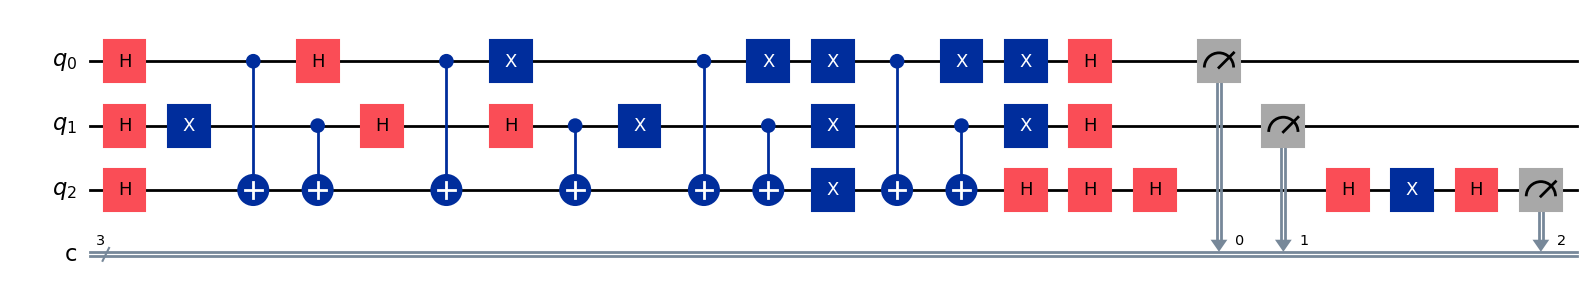

gen = 0 , Best fitness = (np.float64(204.5296875),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(204.1928125),) , Number of invalids = 3


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 1] Best Fitness: 204.1928


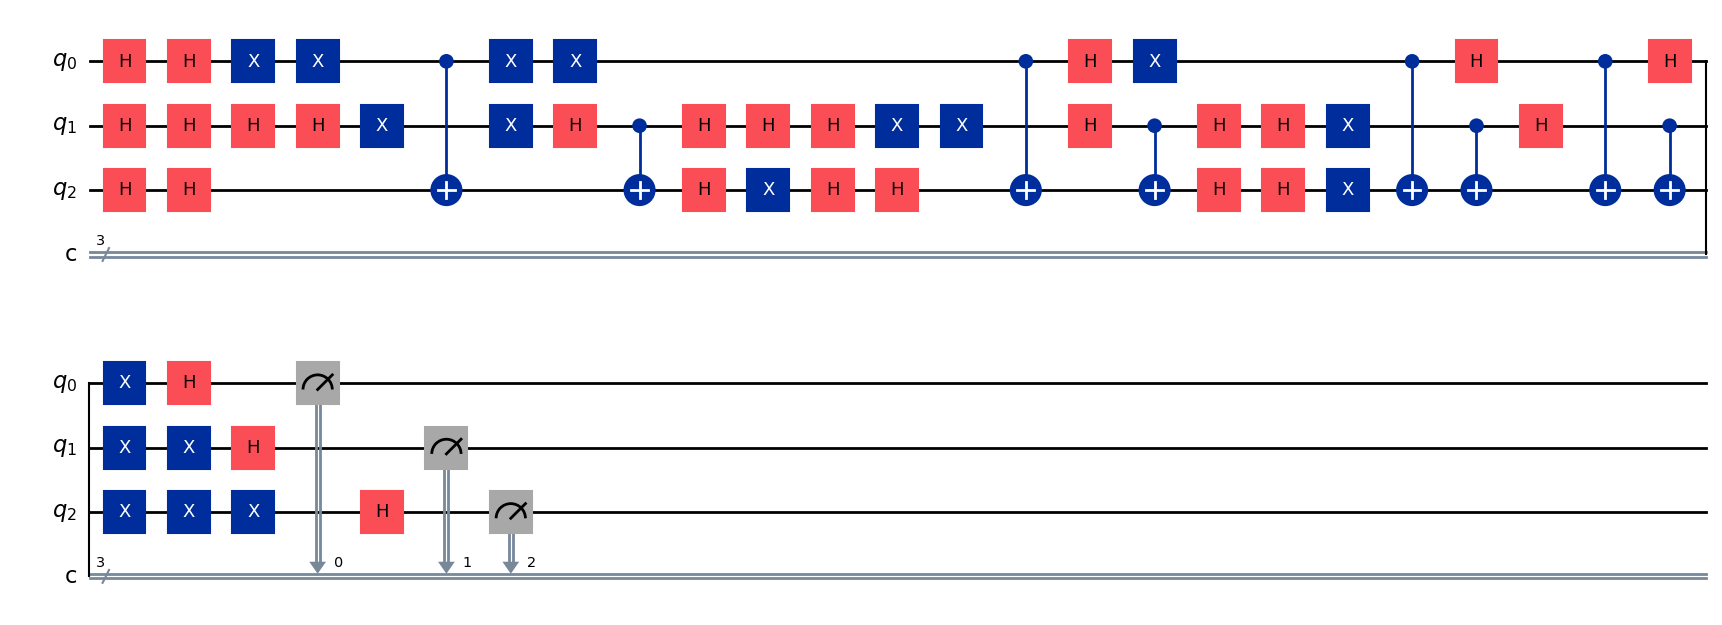

gen = 0 , Best fitness = (np.float64(204.1928125),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(204.1690625),) , Number of invalids = 4


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 2] Best Fitness: 204.1691


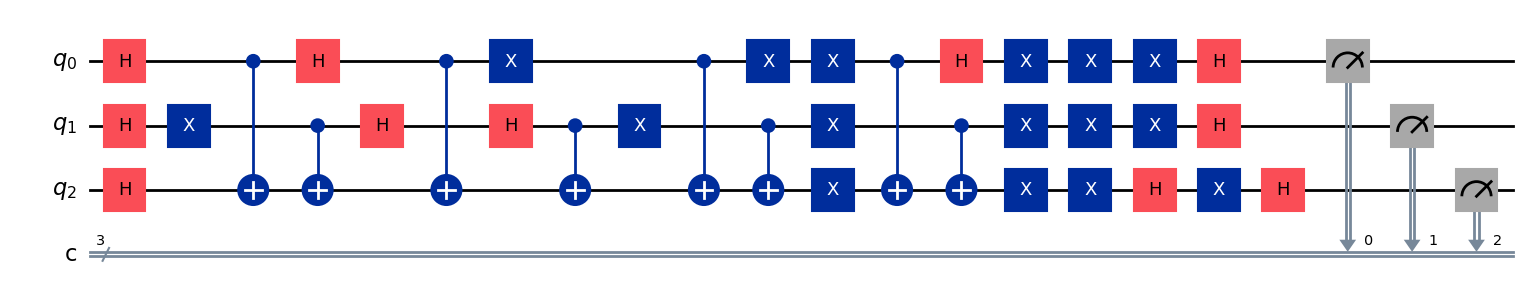

gen = 0 , Best fitness = (np.float64(204.1690625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(204.1690625),) , Number of invalids = 5


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 3] Best Fitness: 204.1691


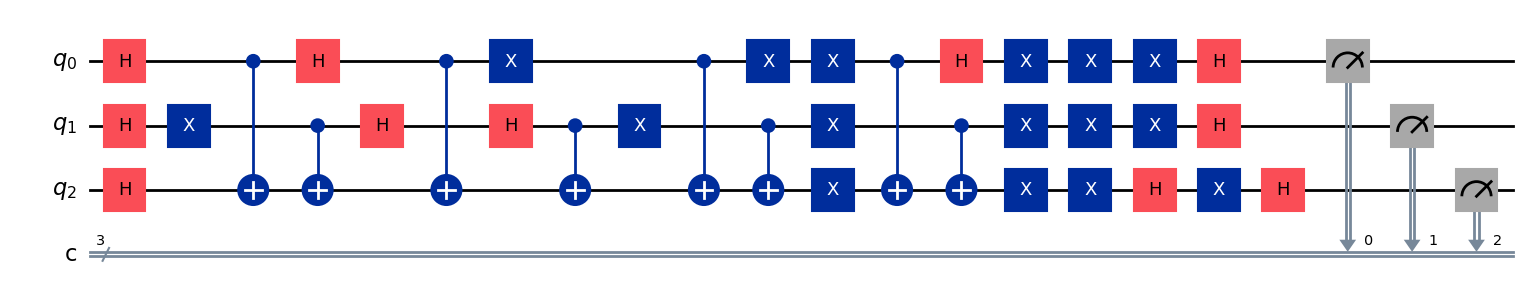

gen = 0 , Best fitness = (np.float64(204.1690625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(204.1690625),) , Number of invalids = 5


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 4] Best Fitness: 204.1691


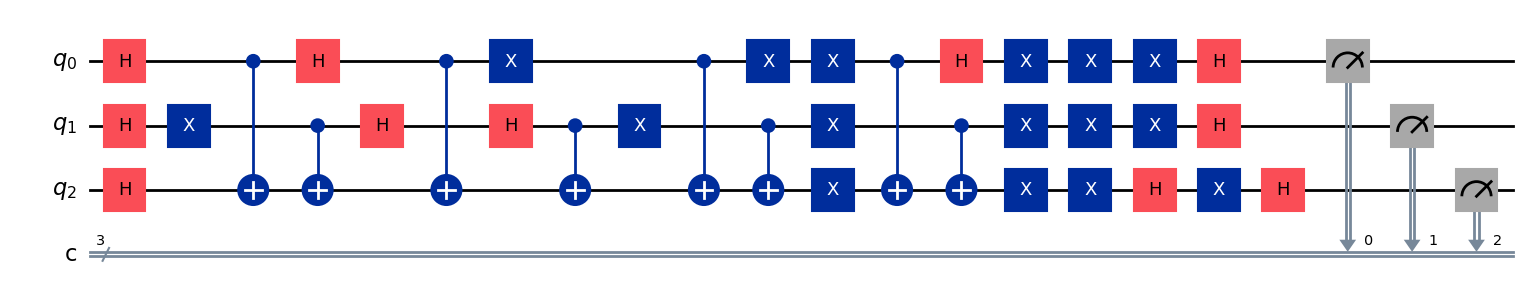

gen = 0 , Best fitness = (np.float64(204.1690625),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 6


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 5] Best Fitness: 203.6794


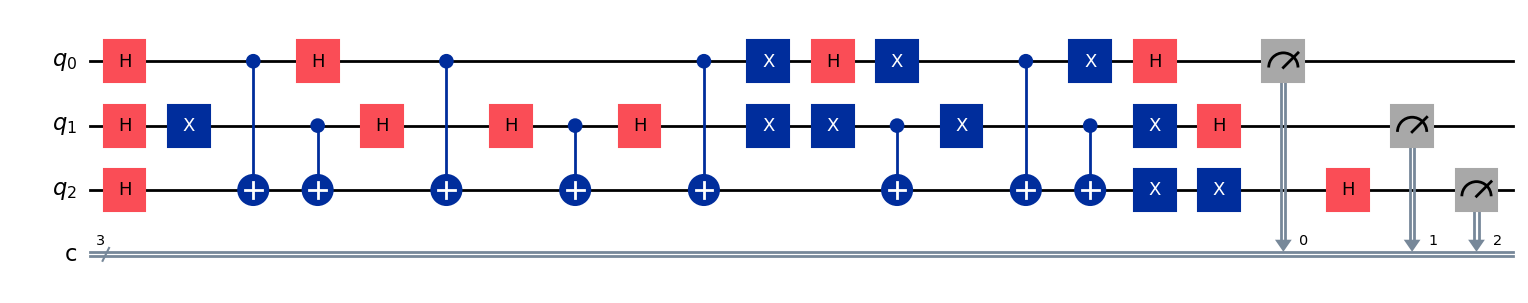

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 6] Best Fitness: 203.6794


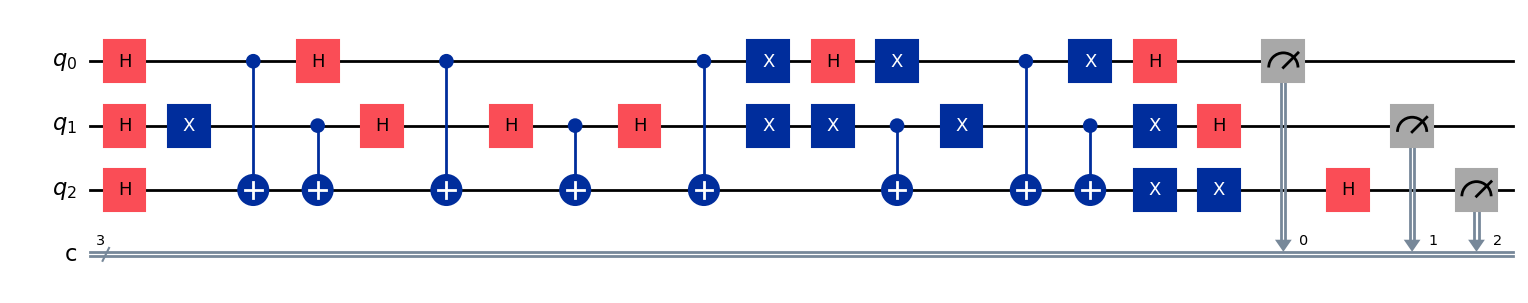

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 2


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 7] Best Fitness: 203.6794


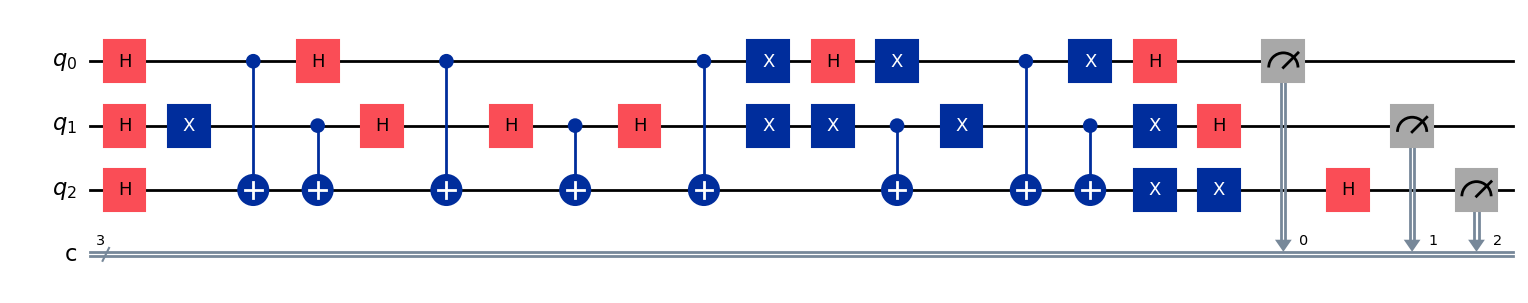

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 8] Best Fitness: 203.6794


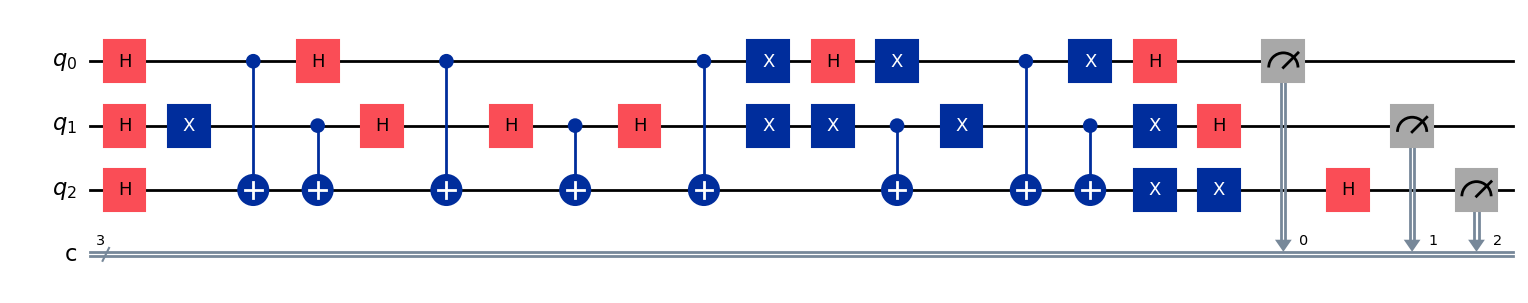

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 9] Best Fitness: 203.6794


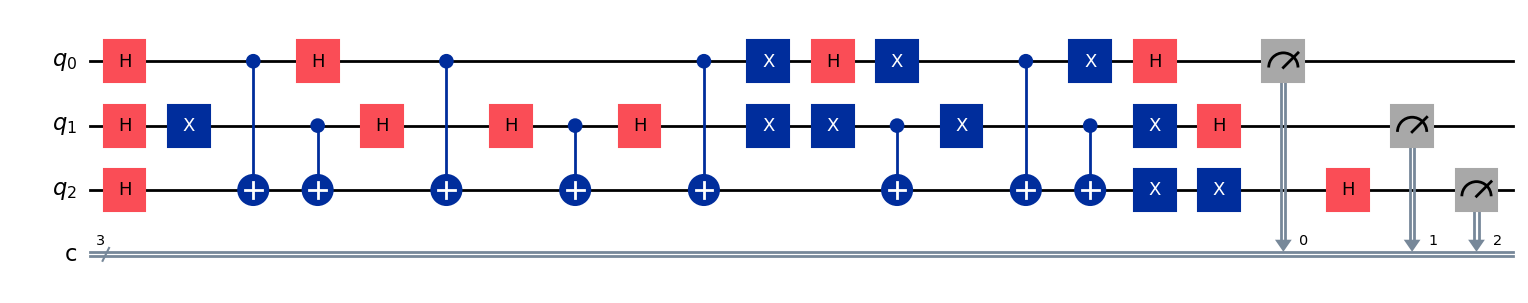

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 10] Best Fitness: 203.6794


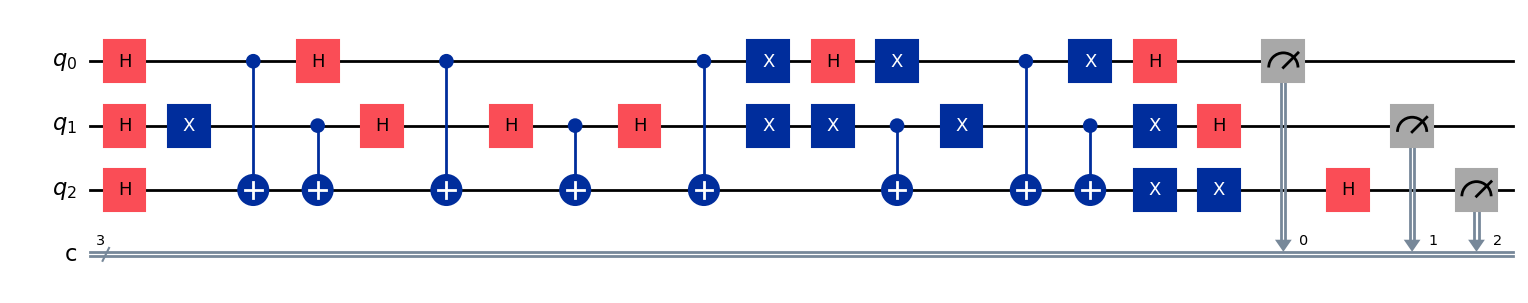

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 11] Best Fitness: 203.6794


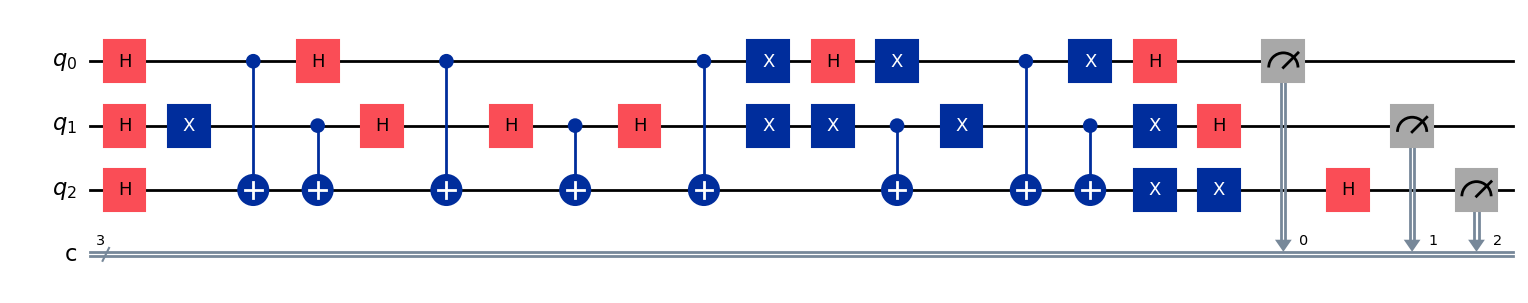

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 12] Best Fitness: 203.6794


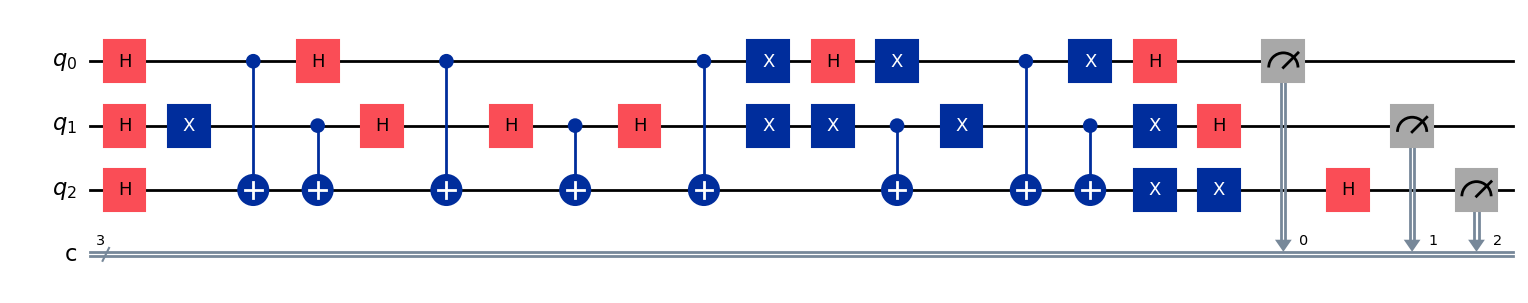

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 13] Best Fitness: 203.6794


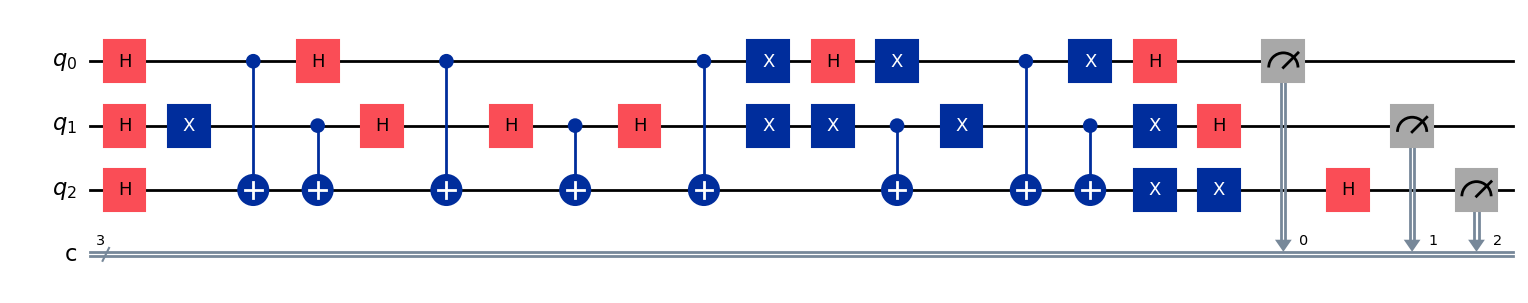

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 14] Best Fitness: 203.6794


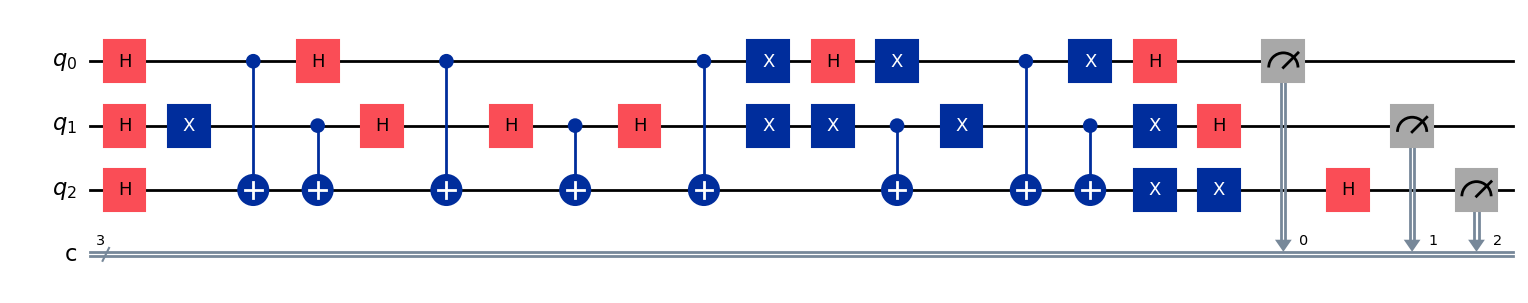

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 2


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 15] Best Fitness: 203.6794


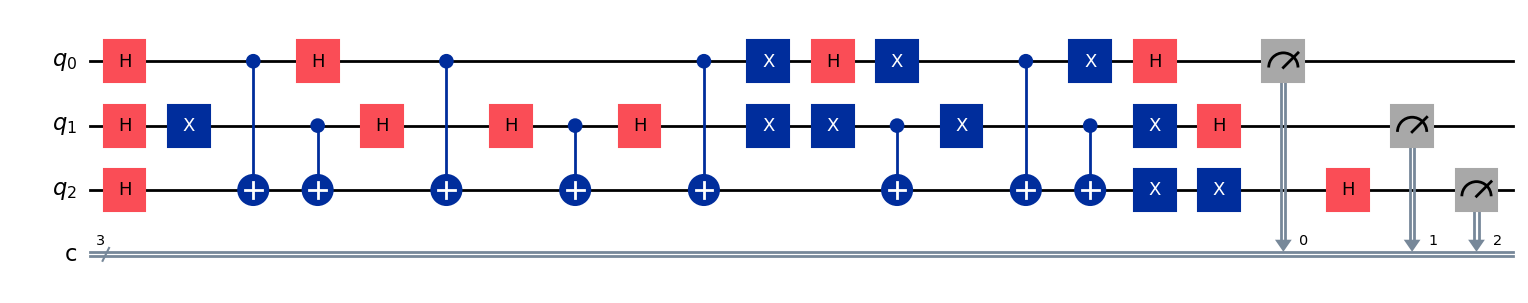

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 16] Best Fitness: 203.6794


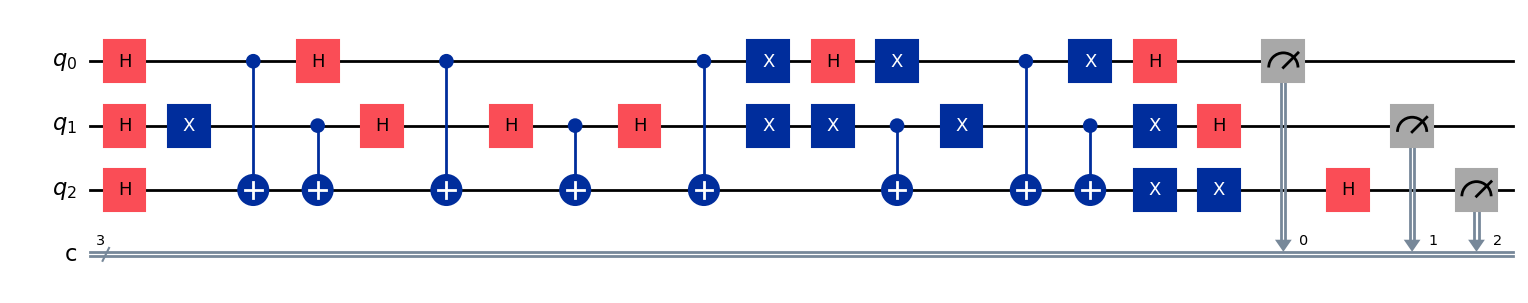

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 3


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 17] Best Fitness: 203.6794


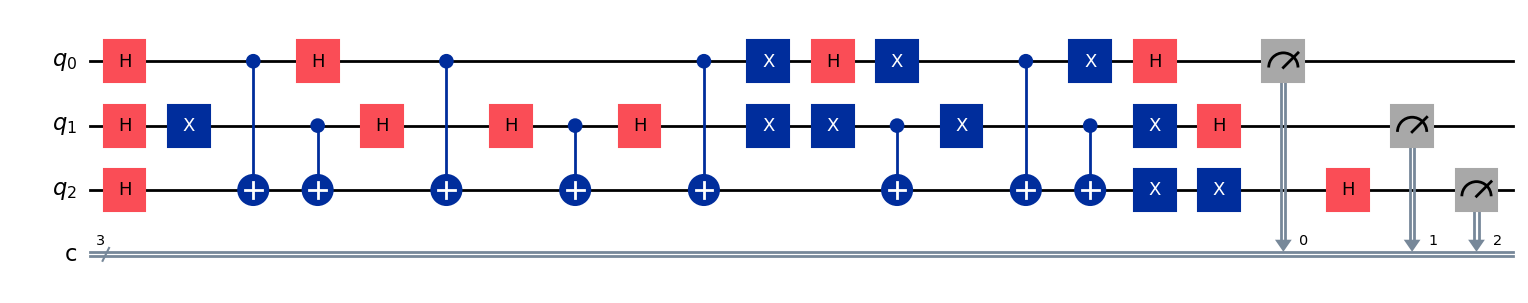

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 18] Best Fitness: 203.6794


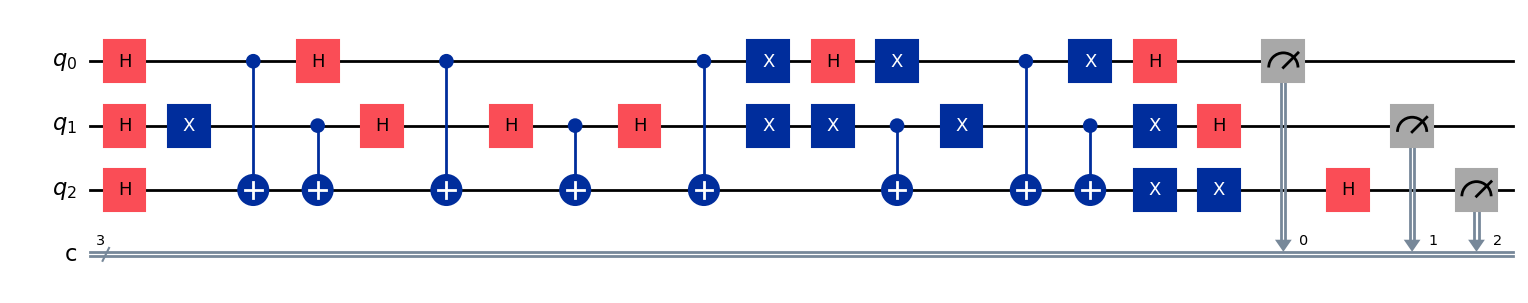

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 19] Best Fitness: 203.6794


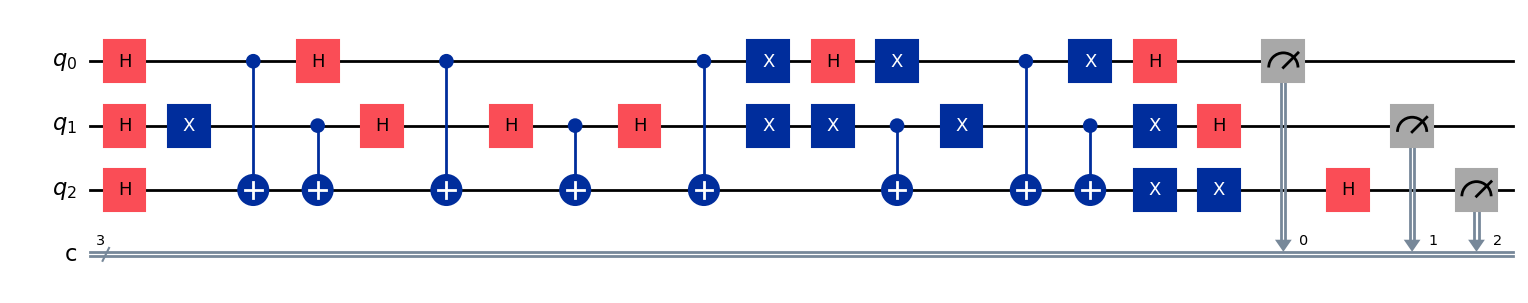

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 20] Best Fitness: 203.6794


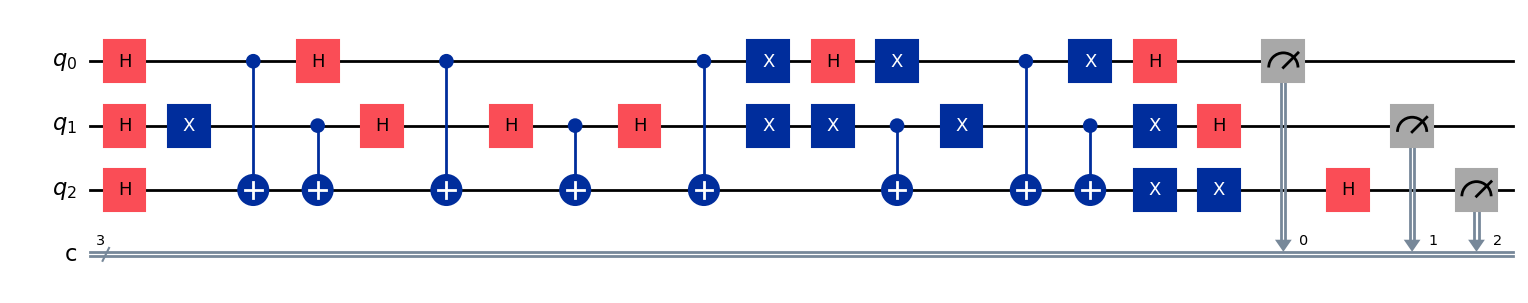

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 21] Best Fitness: 203.6794


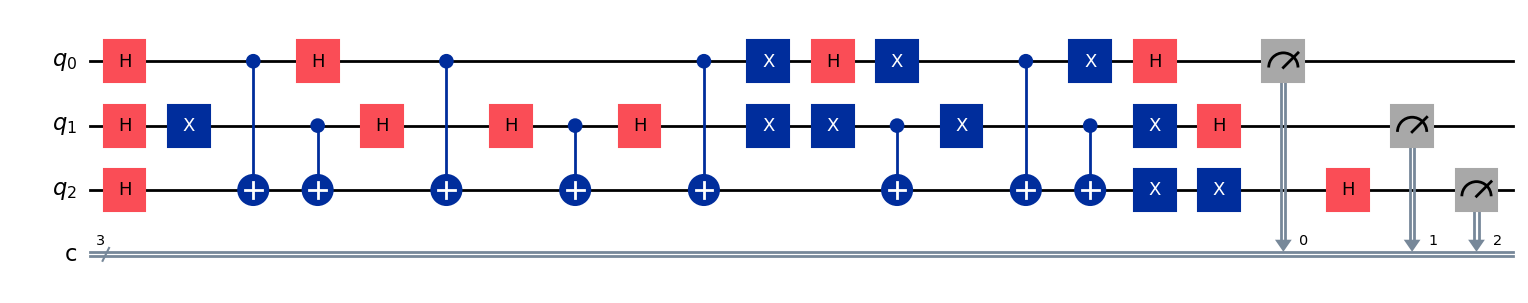

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 22] Best Fitness: 203.6794


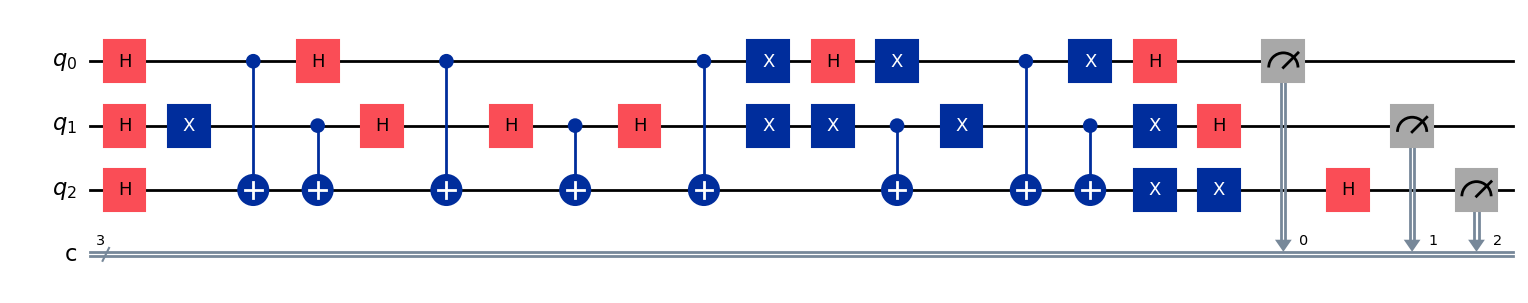

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 23] Best Fitness: 203.6794


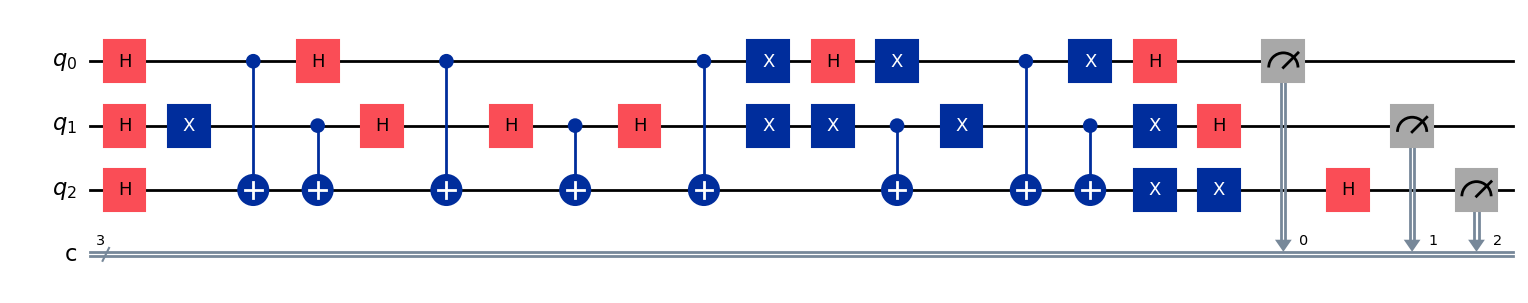

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 24] Best Fitness: 203.6794


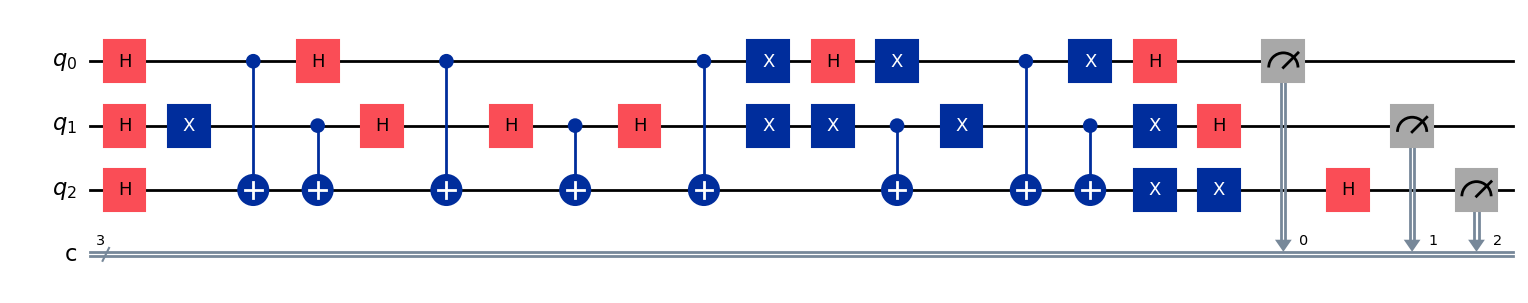

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 25] Best Fitness: 203.6794


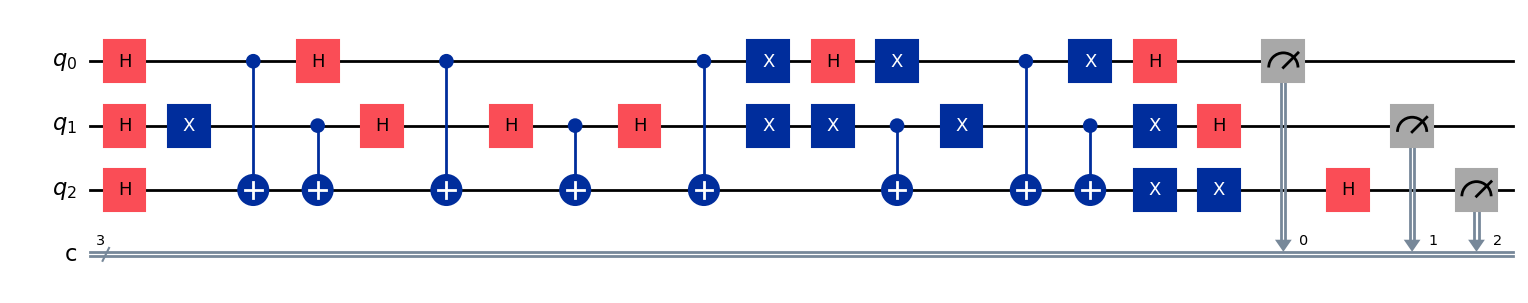

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 26] Best Fitness: 203.6794


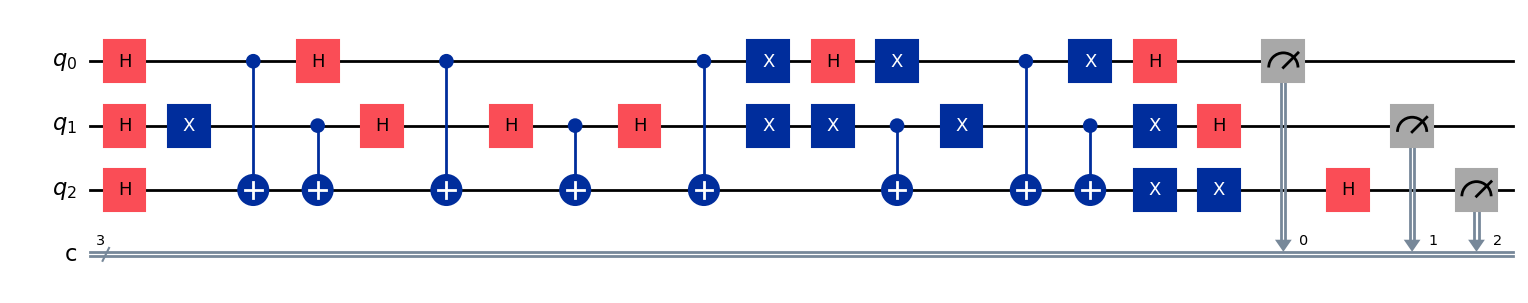

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 2


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 27] Best Fitness: 203.6794


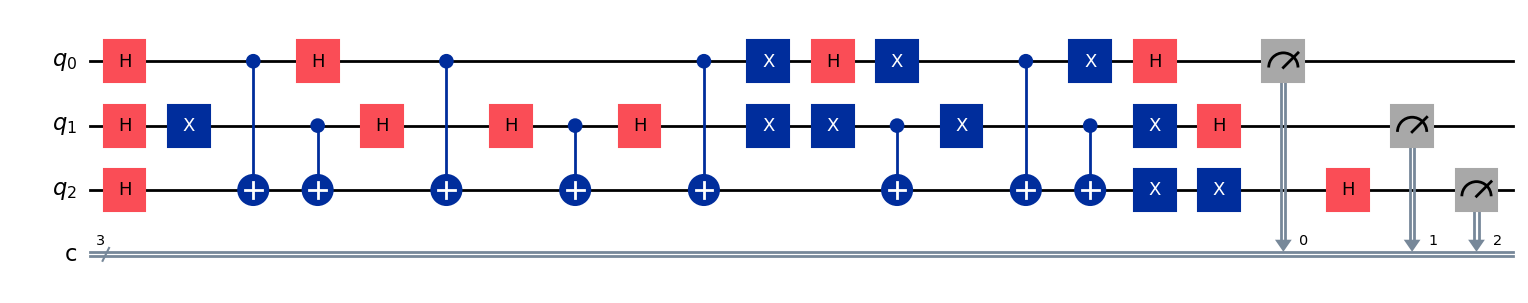

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 28] Best Fitness: 203.6794


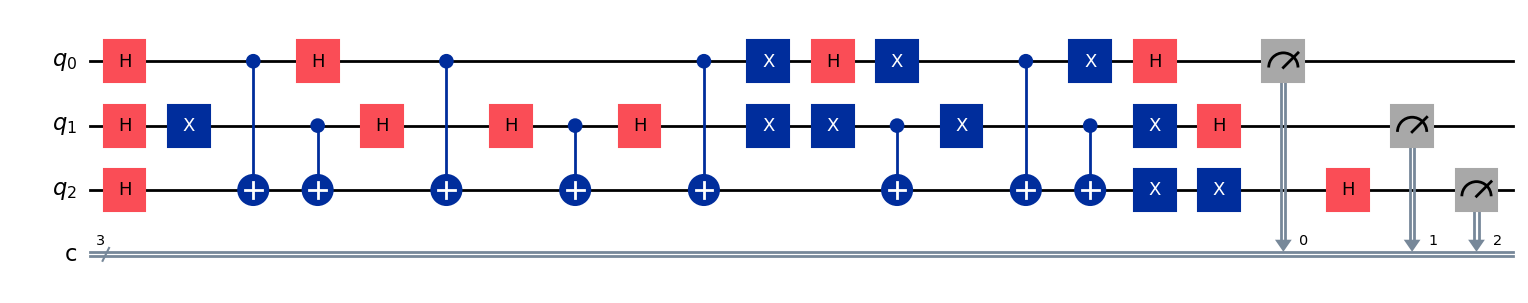

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 4


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 29] Best Fitness: 203.6794


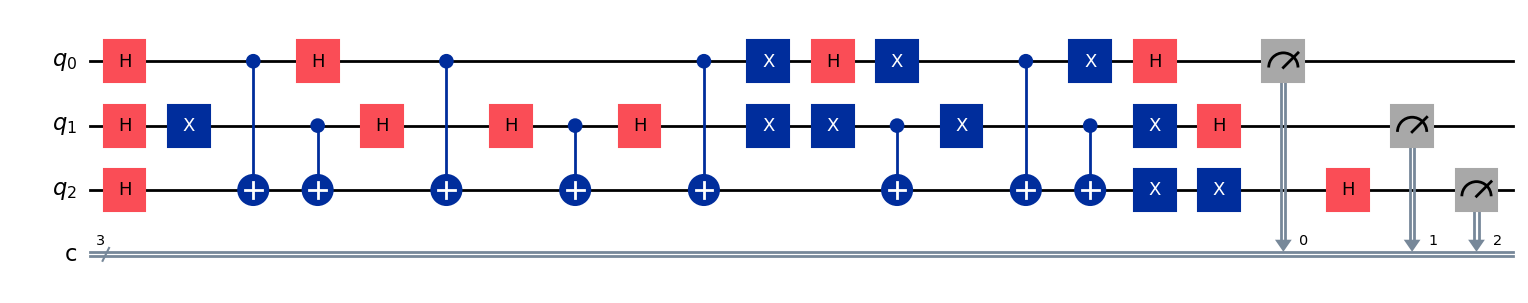

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 6


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 30] Best Fitness: 203.6794


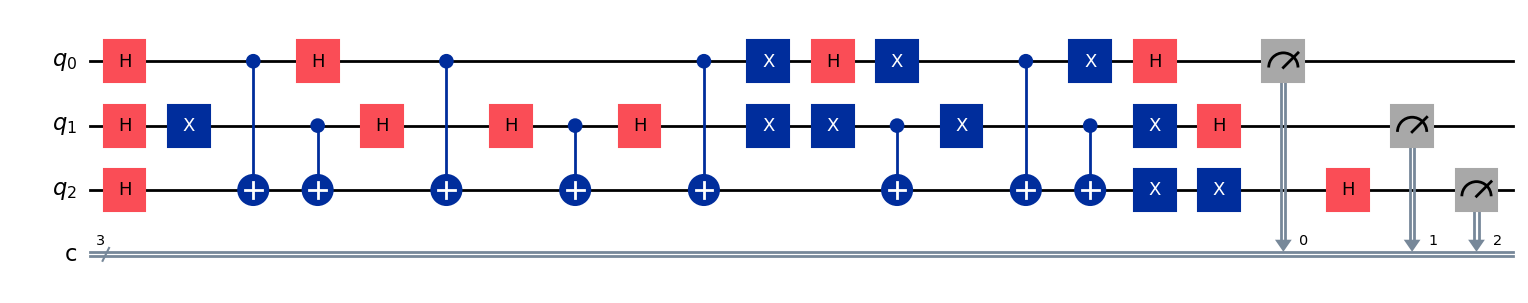

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 31] Best Fitness: 203.6794


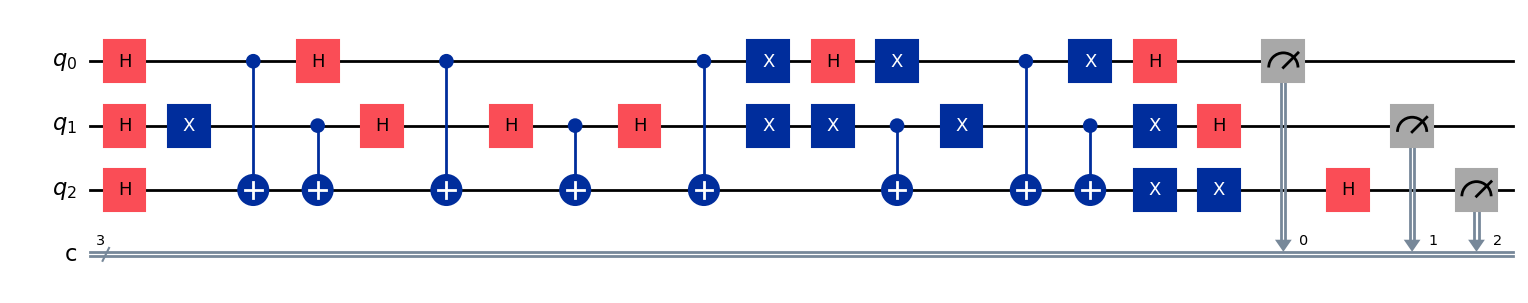

gen = 0 , Best fitness = (np.float64(203.679375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 32] Best Fitness: 203.6794


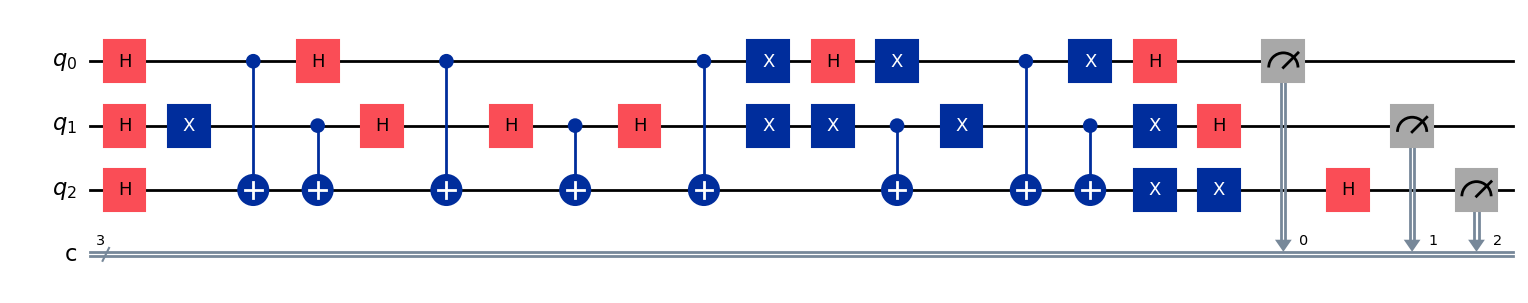

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.679375),) , Number of invalids = 0

[Generation 33] Best Fitness: 203.6794


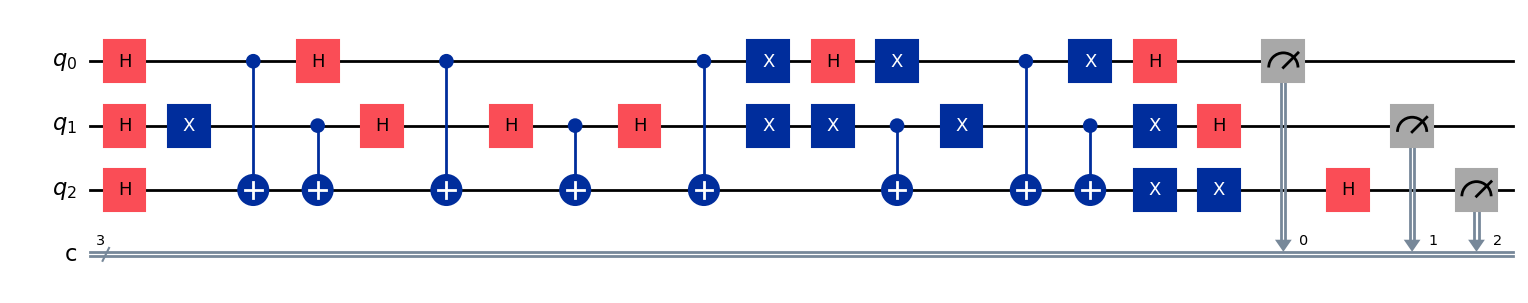

gen = 0 , Best fitness = (np.float64(203.679375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 34] Best Fitness: 203.4859


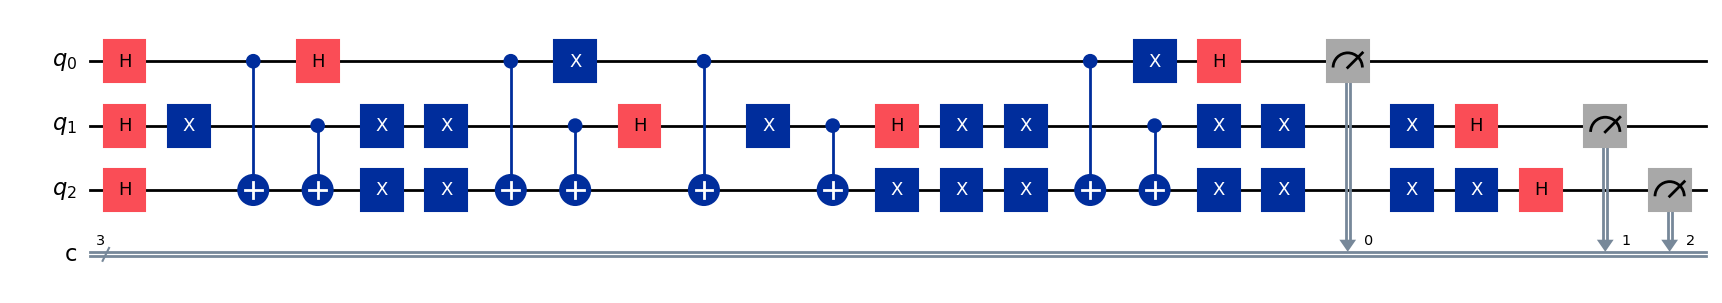

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 35] Best Fitness: 203.4859


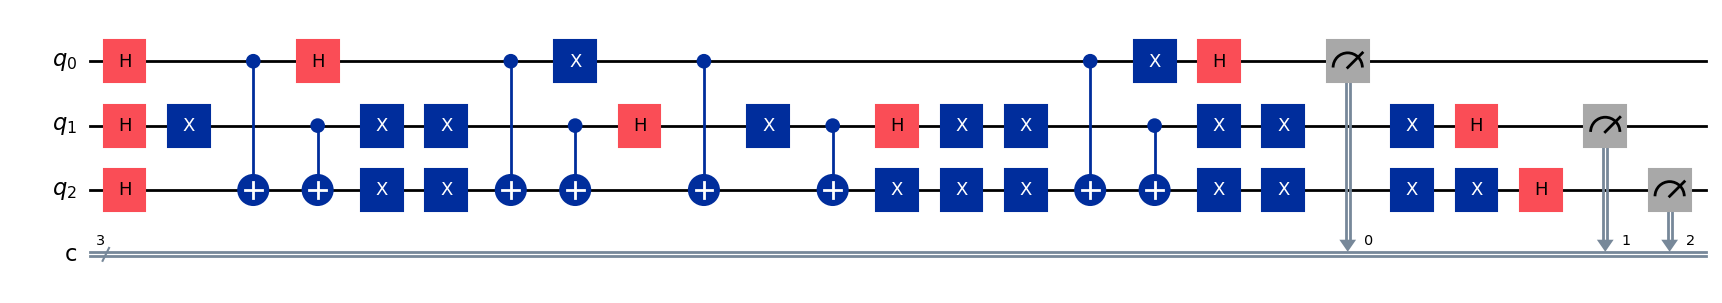

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 36] Best Fitness: 203.4859


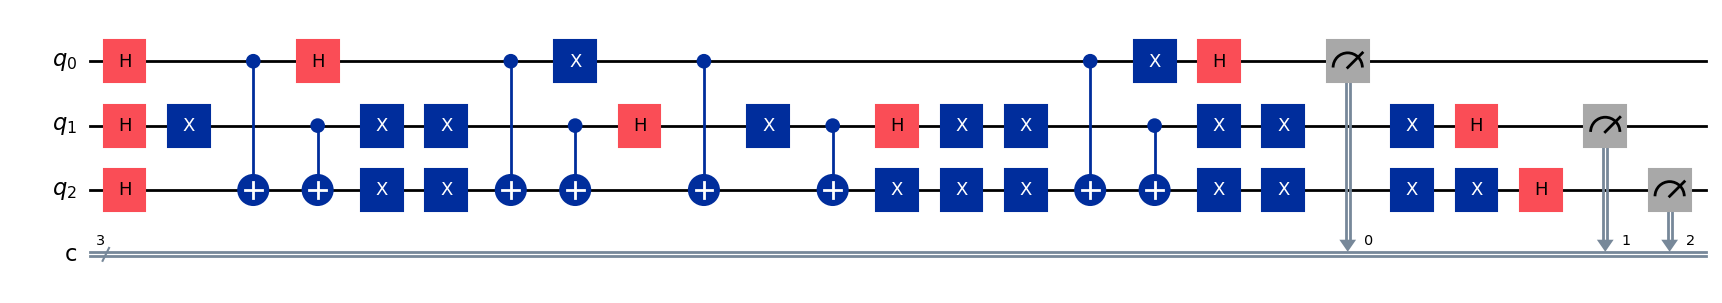

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 37] Best Fitness: 203.4859


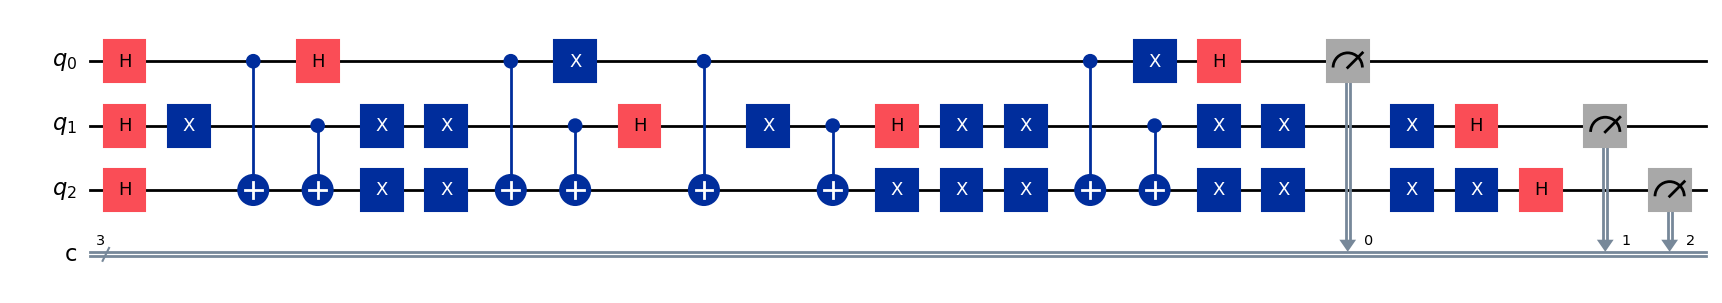

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 38] Best Fitness: 203.4859


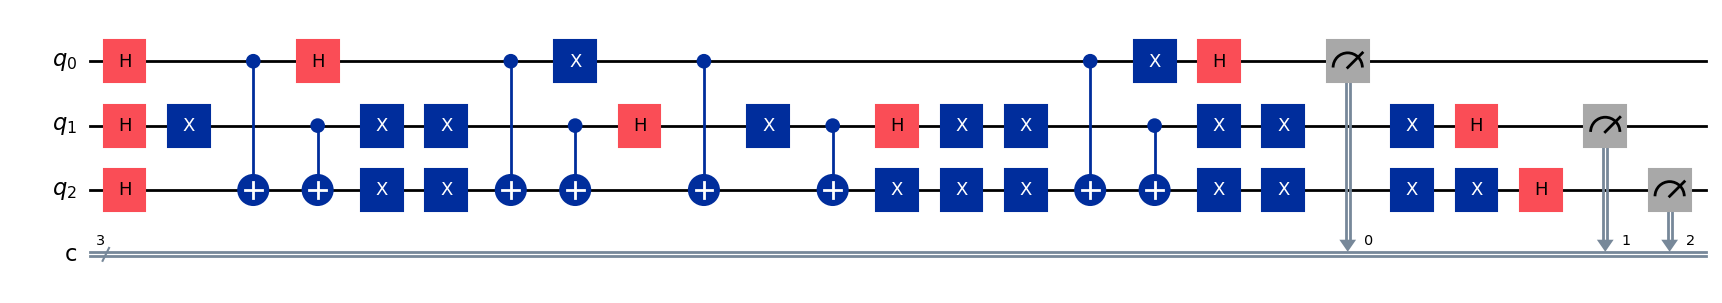

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 39] Best Fitness: 203.4859


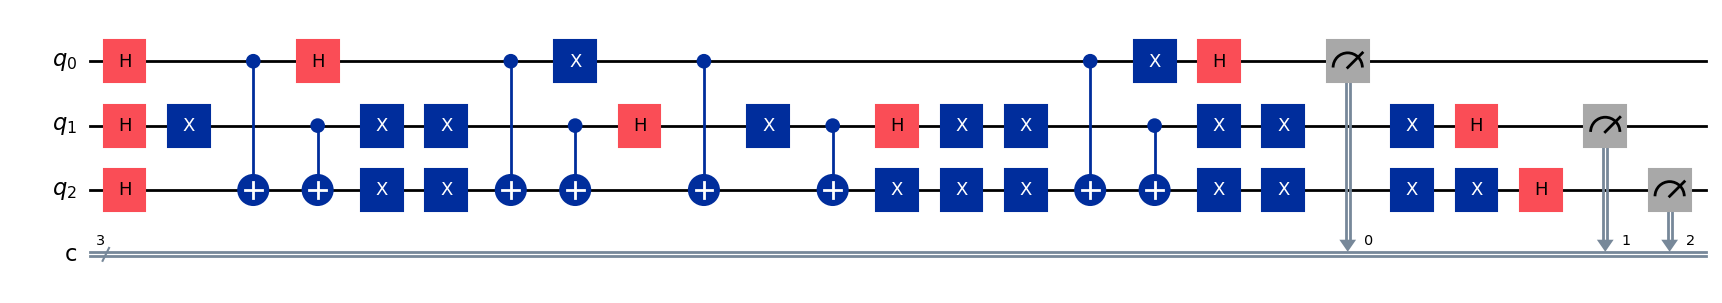

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 40] Best Fitness: 203.4859


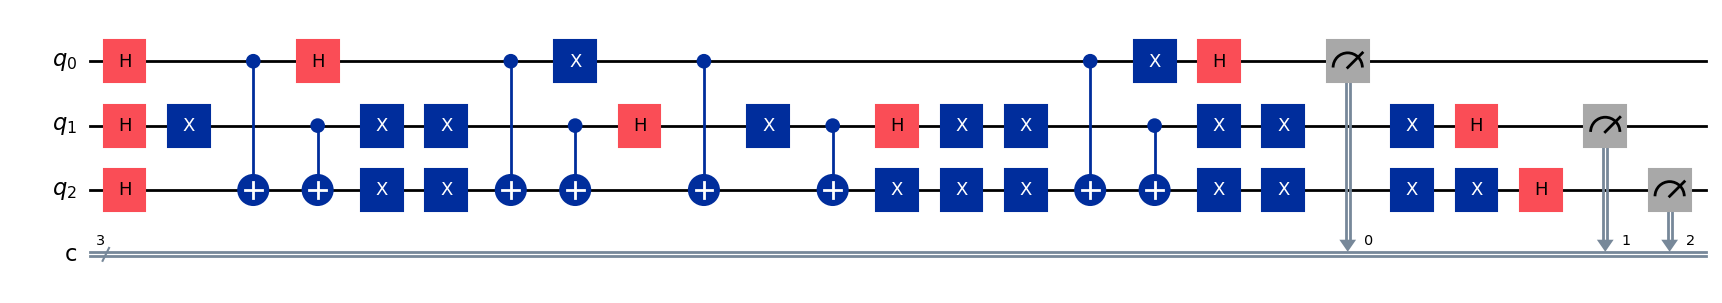

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 41] Best Fitness: 203.4859


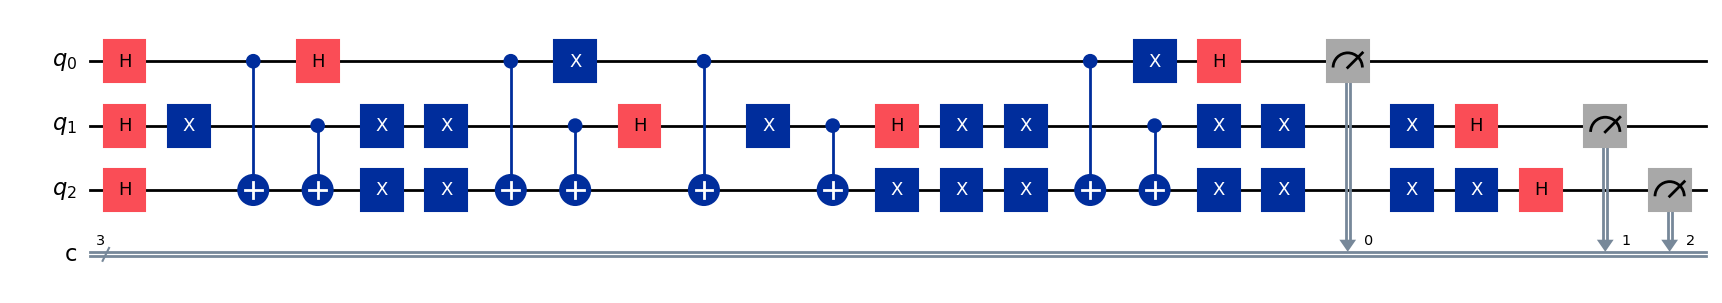

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 42] Best Fitness: 203.4859


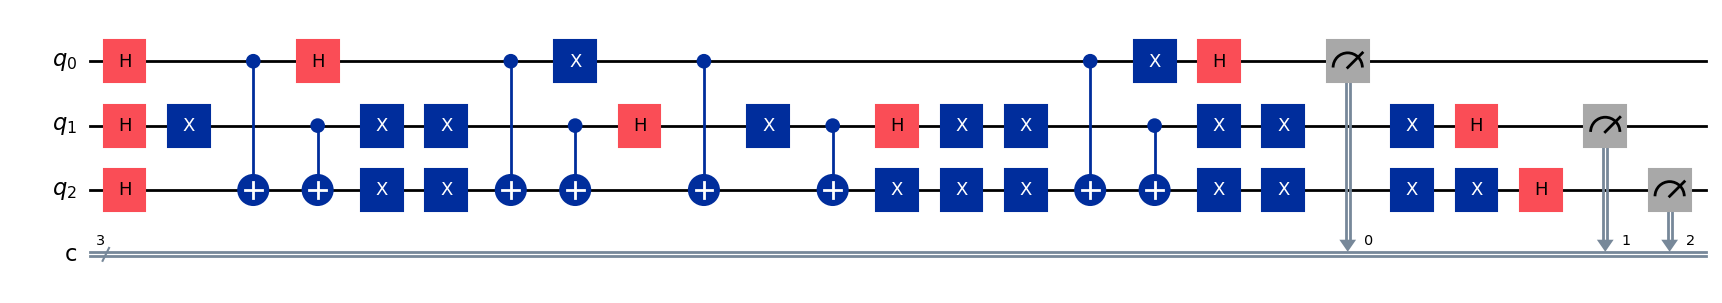

gen = 0 , Best fitness = (np.float64(203.4859375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 43] Best Fitness: 203.4859


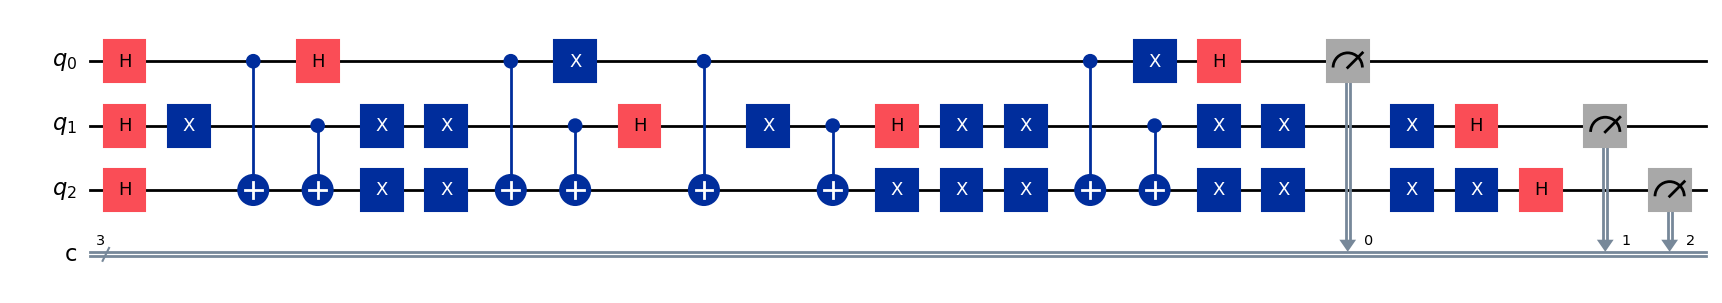

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 44] Best Fitness: 203.4859


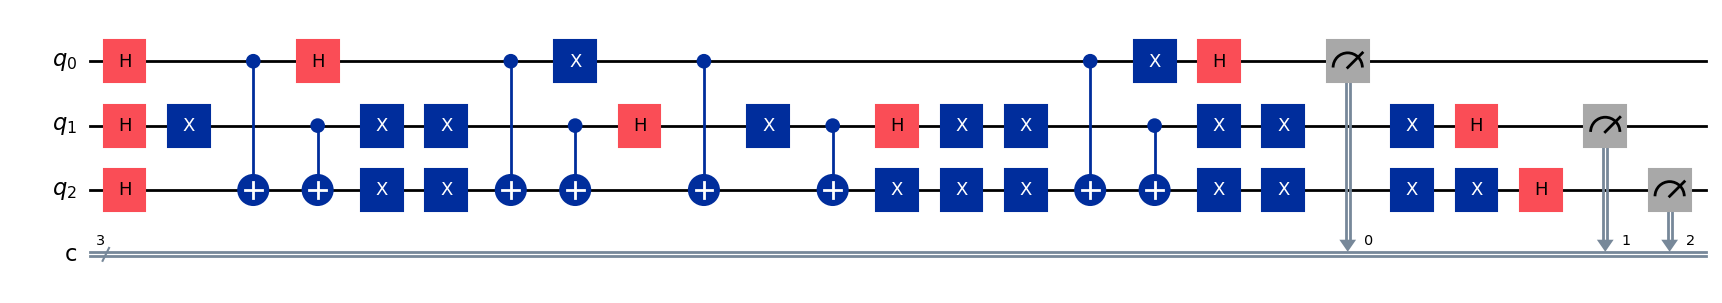

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 45] Best Fitness: 203.4859


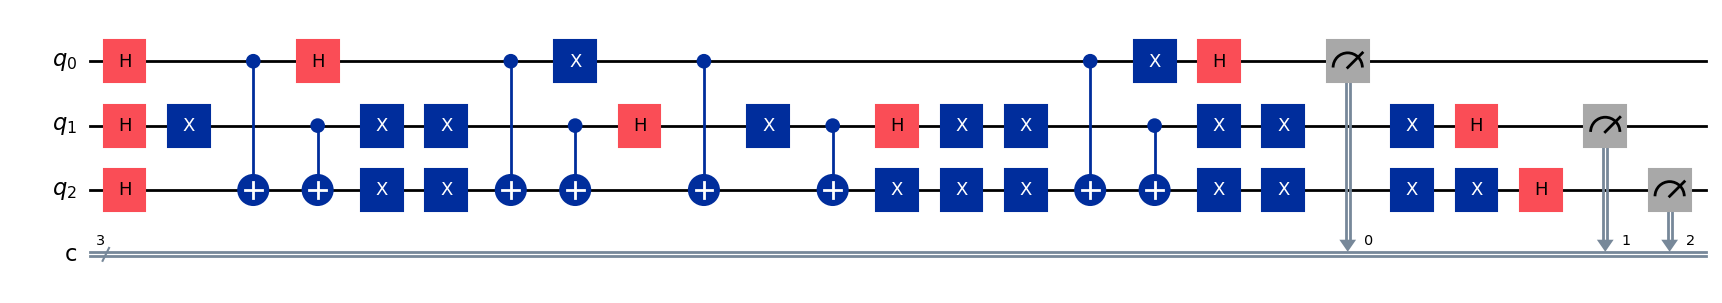

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 46] Best Fitness: 203.4859


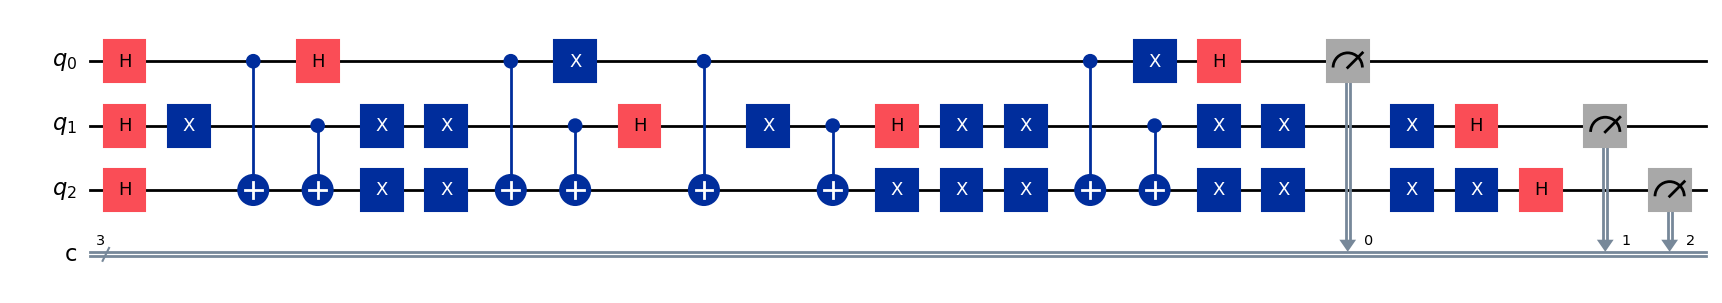

gen = 0 , Best fitness = (np.float64(203.4859375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 47] Best Fitness: 203.4859


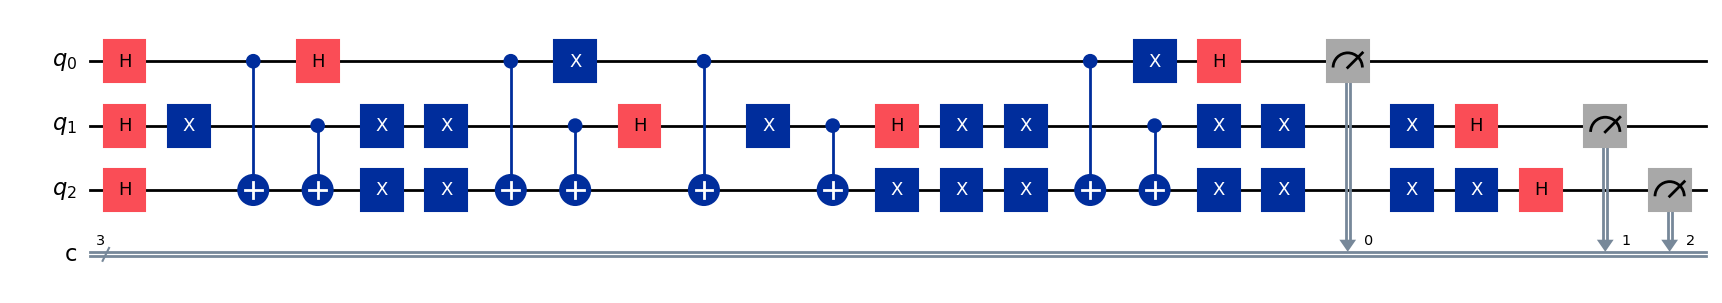

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 48] Best Fitness: 203.4859


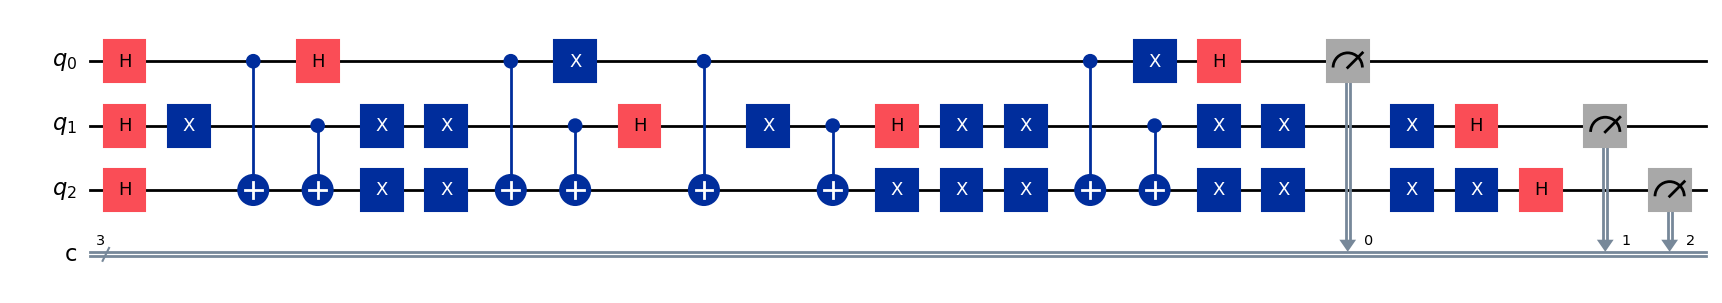

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 49] Best Fitness: 203.4859


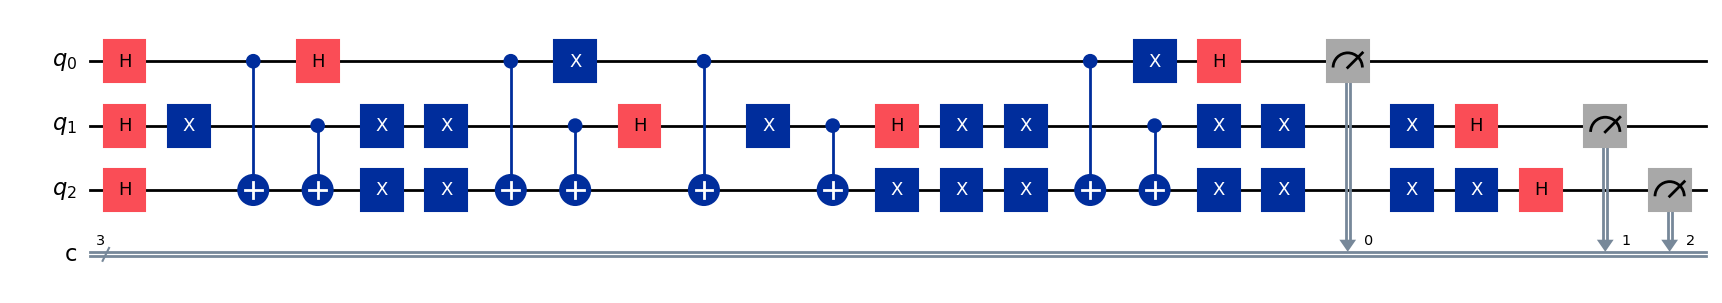

gen = 0 , Best fitness = (np.float64(203.4859375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 50] Best Fitness: 203.4859


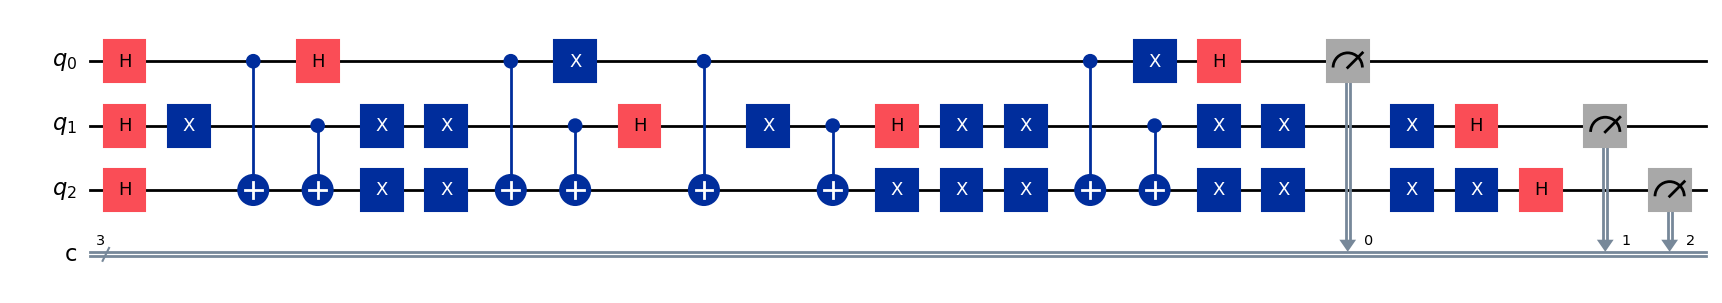

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 51] Best Fitness: 203.4859


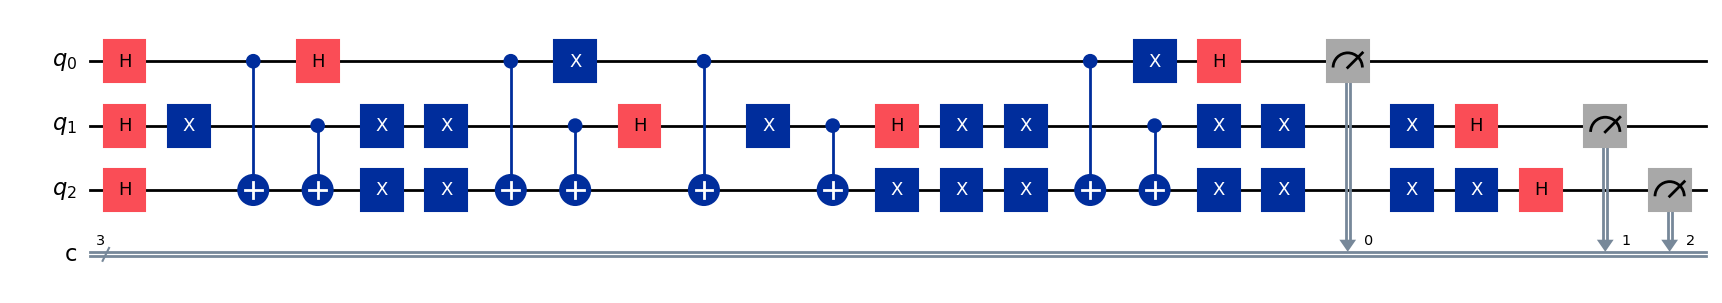

gen = 0 , Best fitness = (np.float64(203.4859375),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 52] Best Fitness: 203.4859


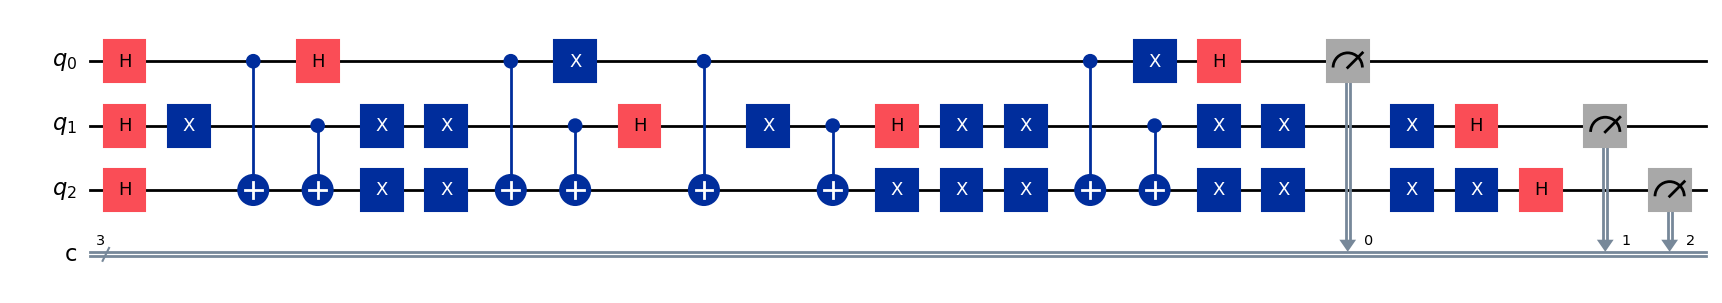

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 53] Best Fitness: 203.4859


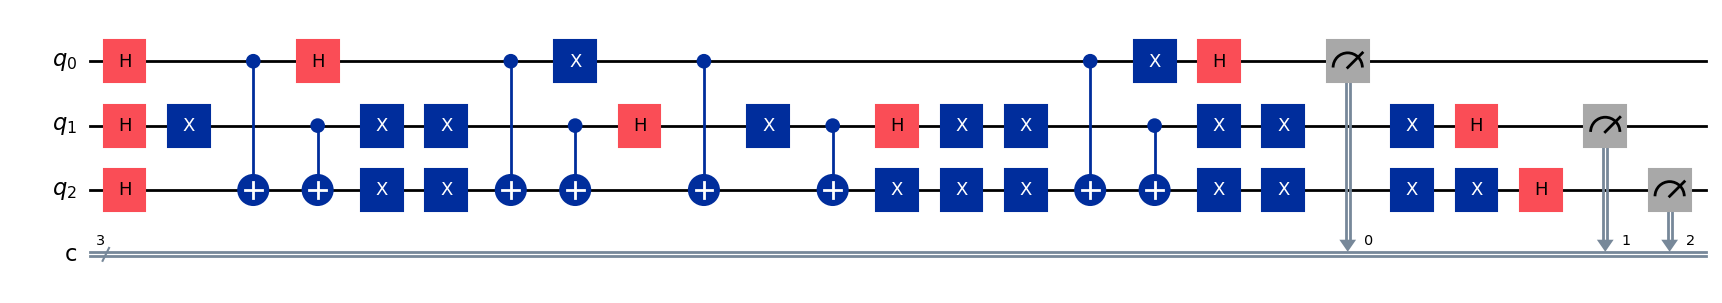

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 54] Best Fitness: 203.4859


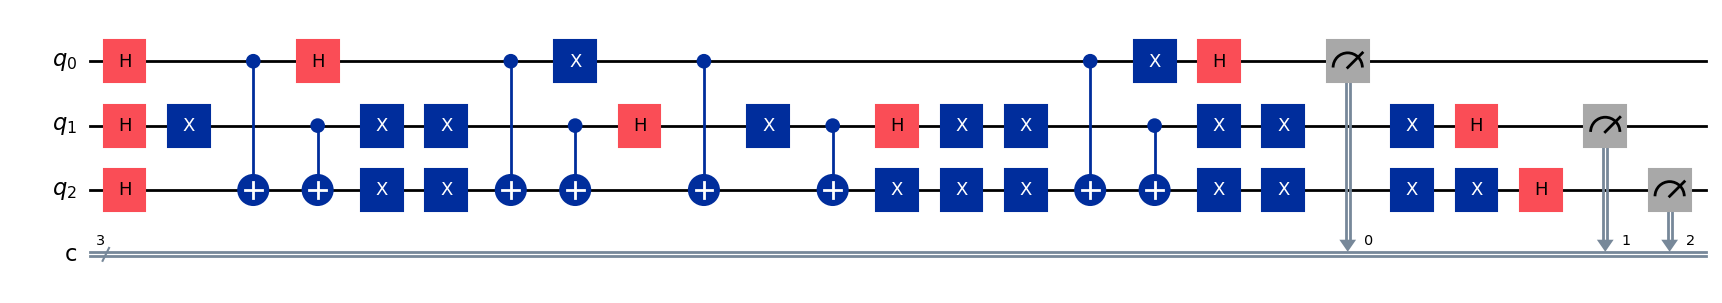

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 55] Best Fitness: 203.4859


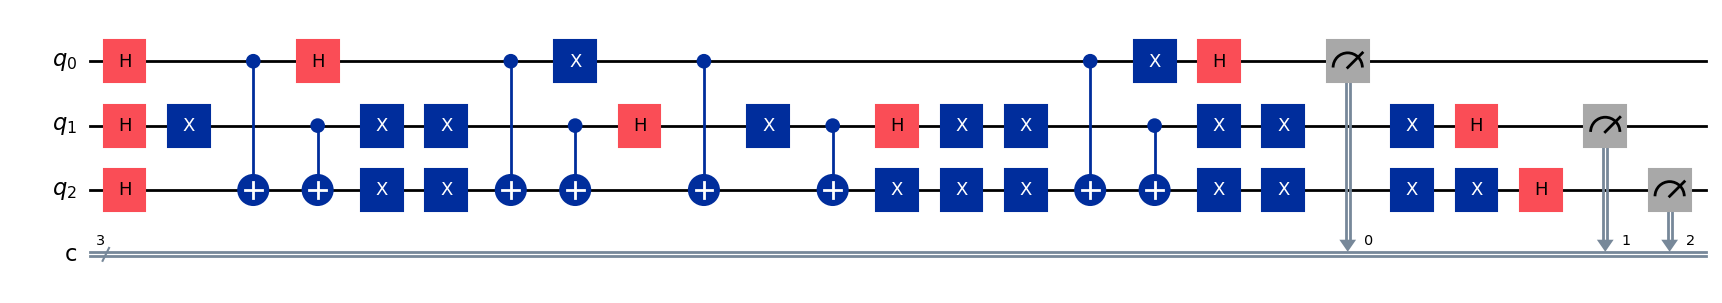

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 56] Best Fitness: 203.4859


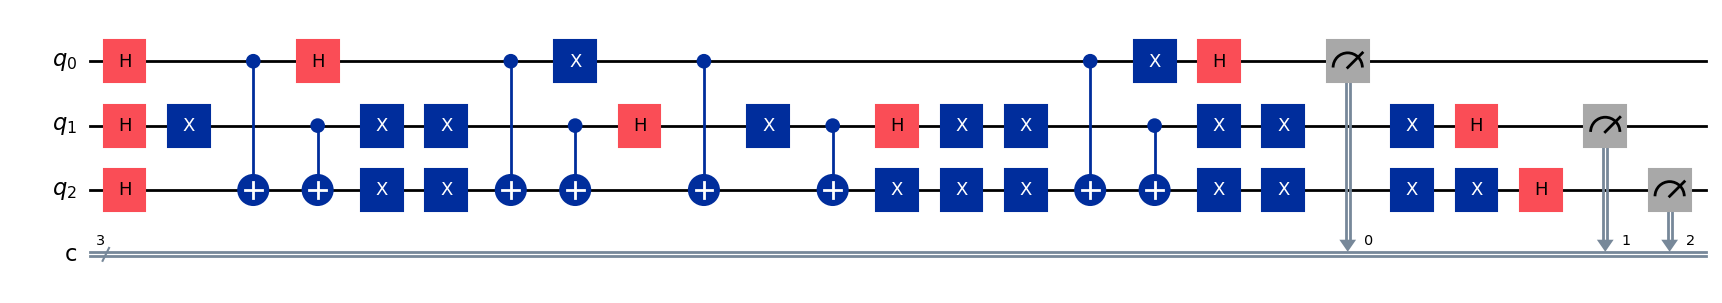

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 57] Best Fitness: 203.4859


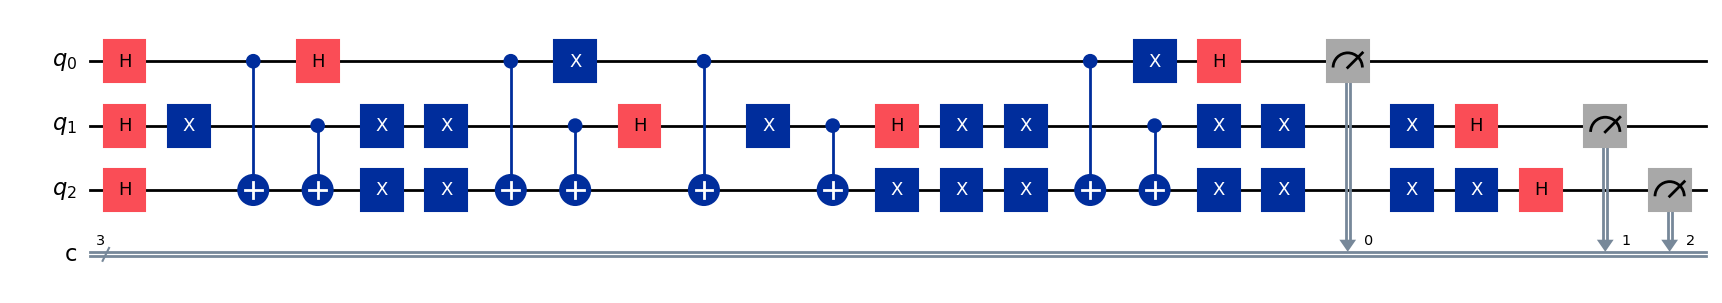

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 58] Best Fitness: 203.4859


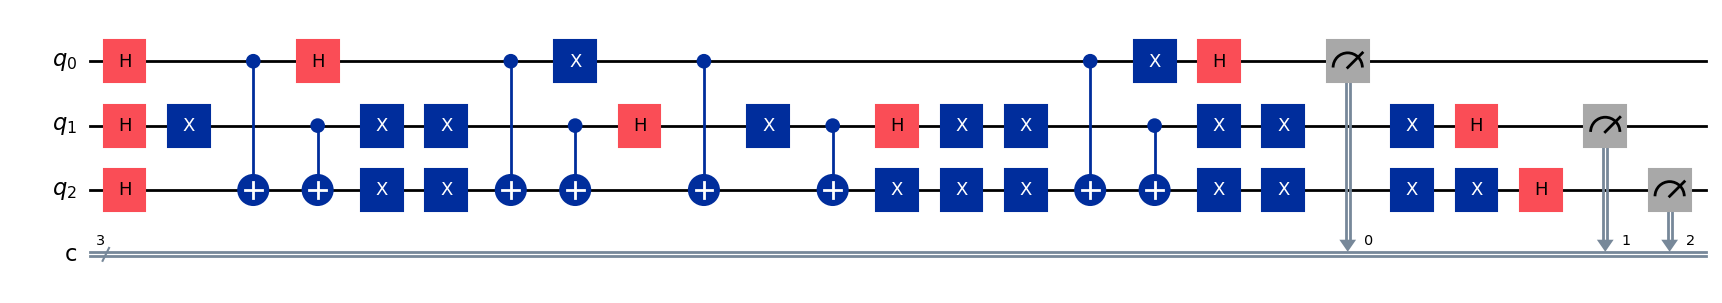

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.4859375),) , Number of invalids = 0

[Generation 59] Best Fitness: 203.4859


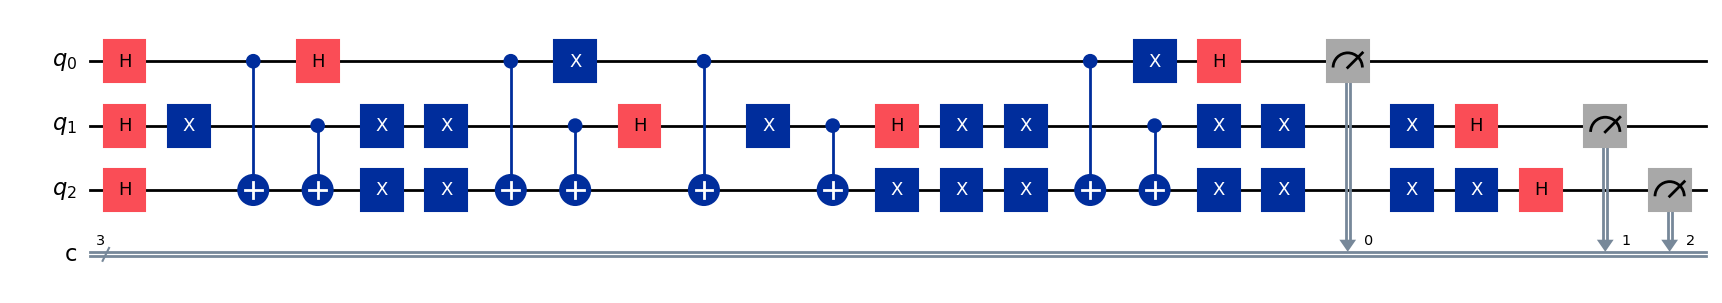

gen = 0 , Best fitness = (np.float64(203.4859375),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 1


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



[Generation 60] Best Fitness: 203.4650


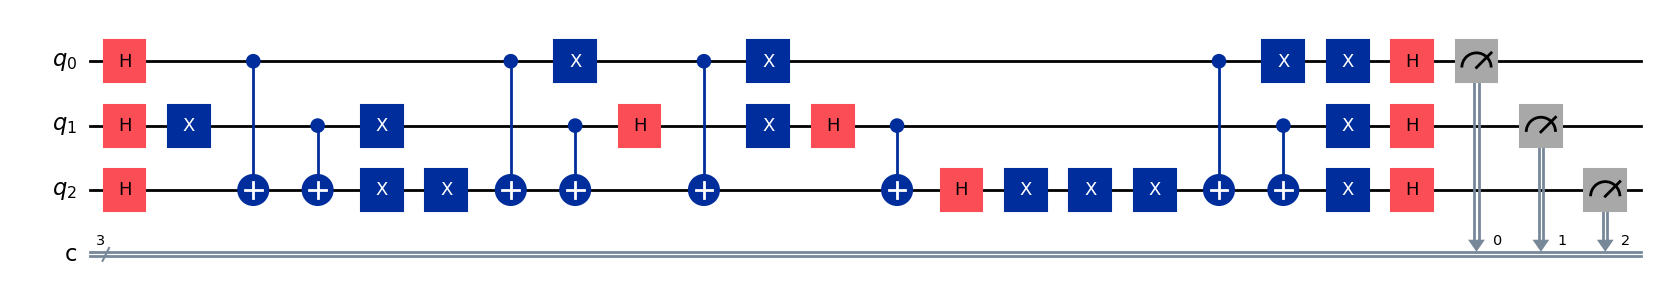

gen = 0 , Best fitness = (np.float64(203.465),)


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 61] Best Fitness: 203.4650


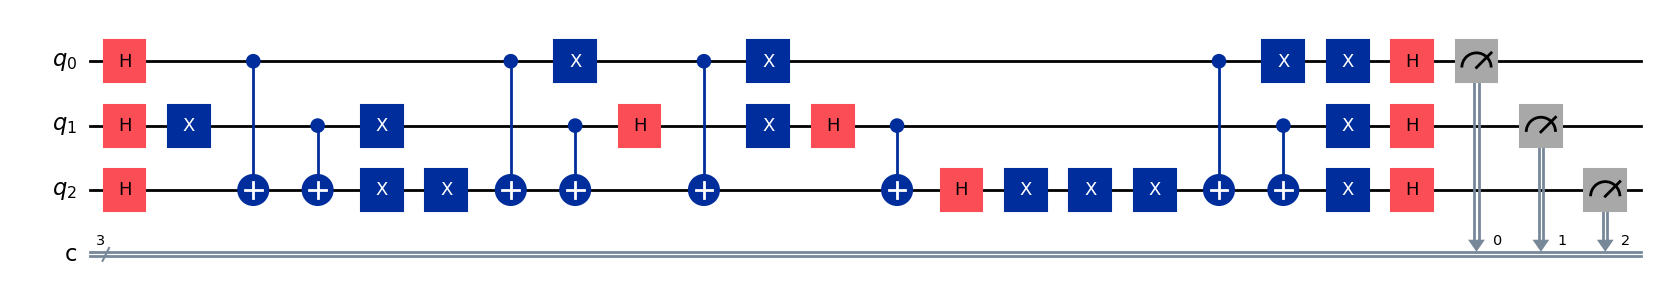

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 62] Best Fitness: 203.4650


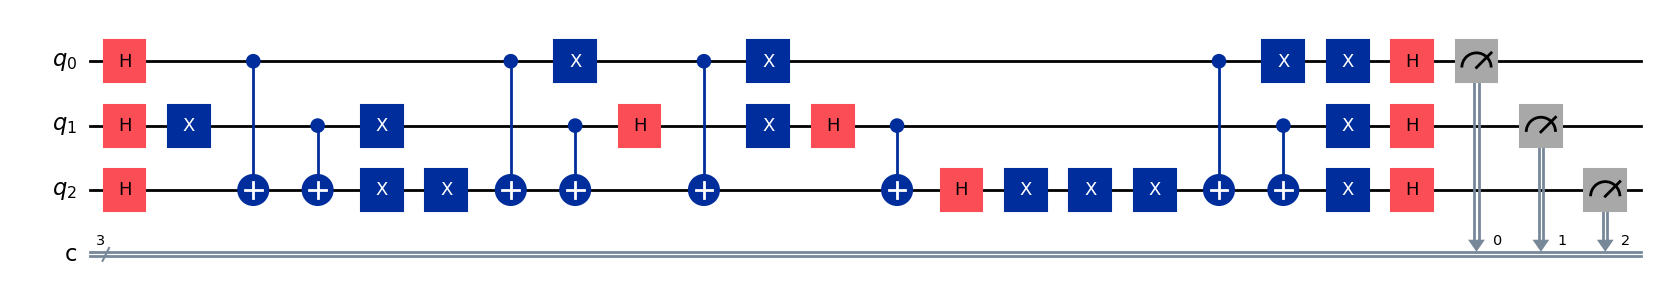

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 63] Best Fitness: 203.4650


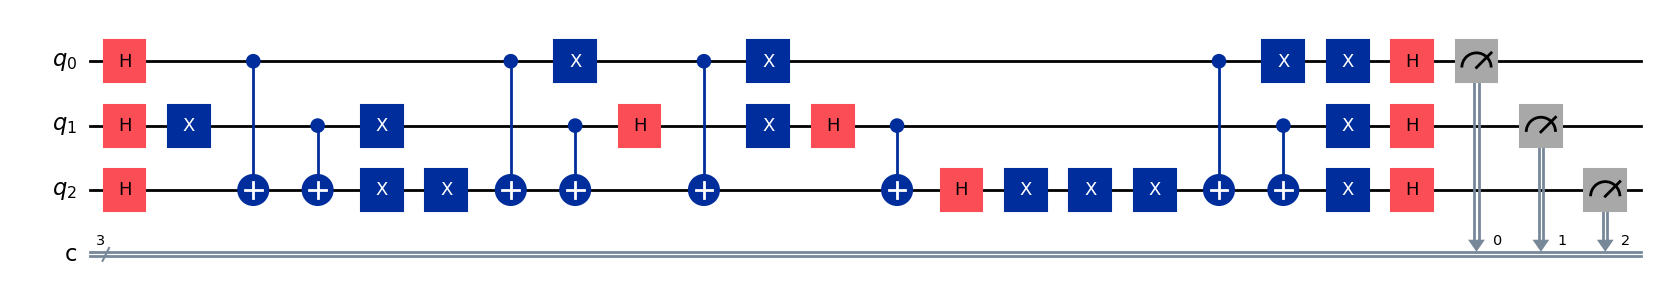

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 64] Best Fitness: 203.4650


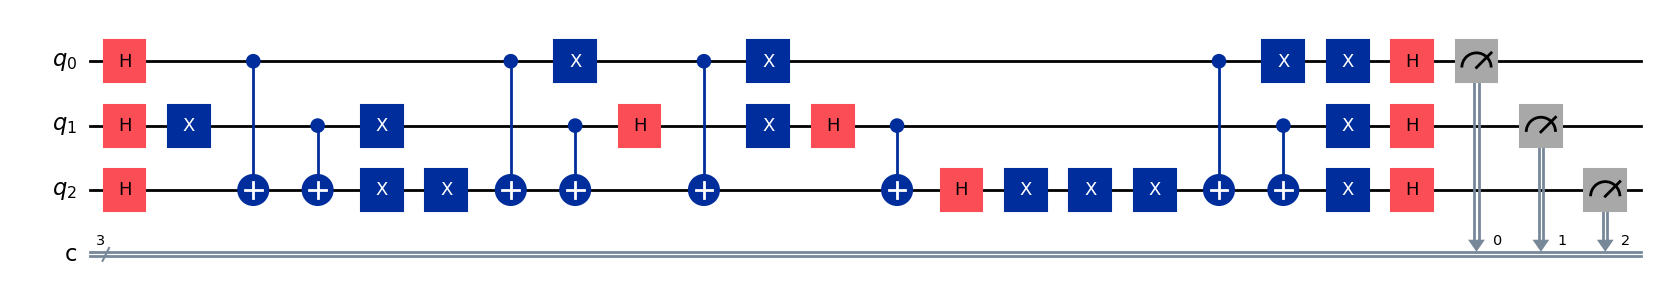

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 65] Best Fitness: 203.4650


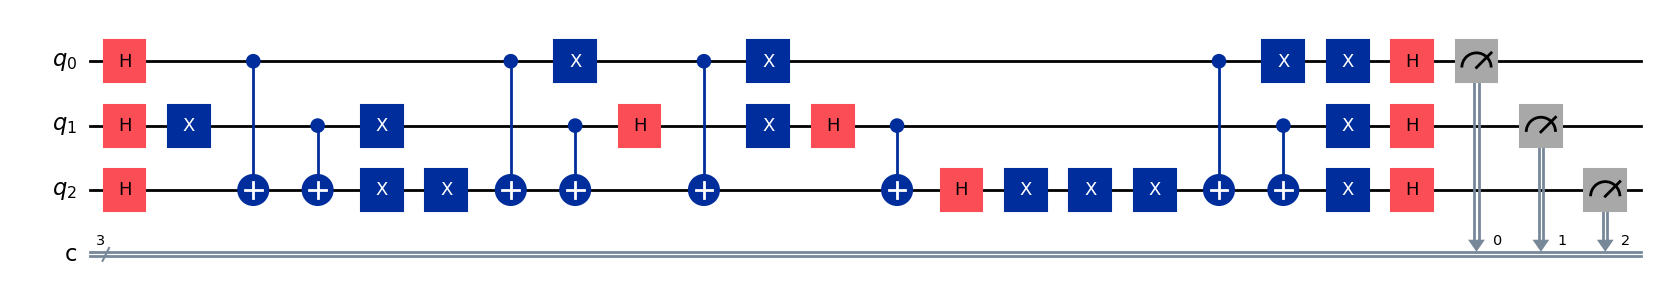

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 66] Best Fitness: 203.4650


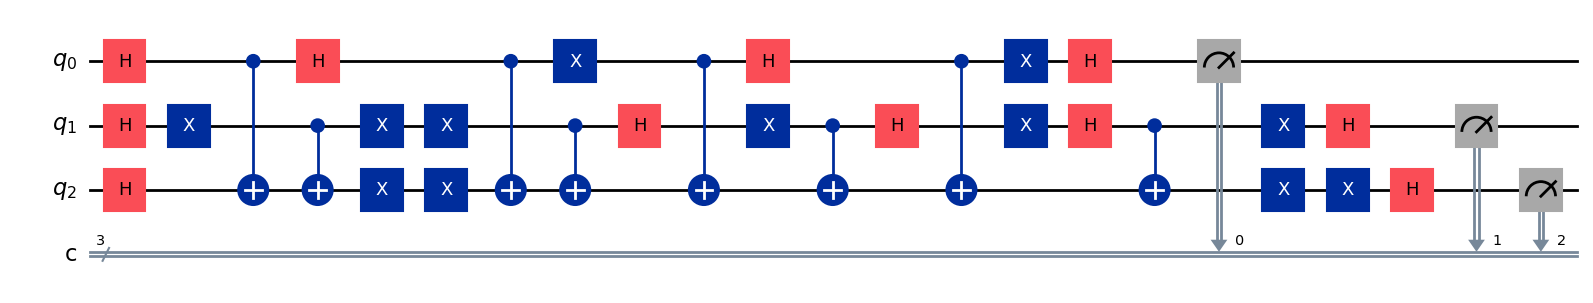

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 67] Best Fitness: 203.4650


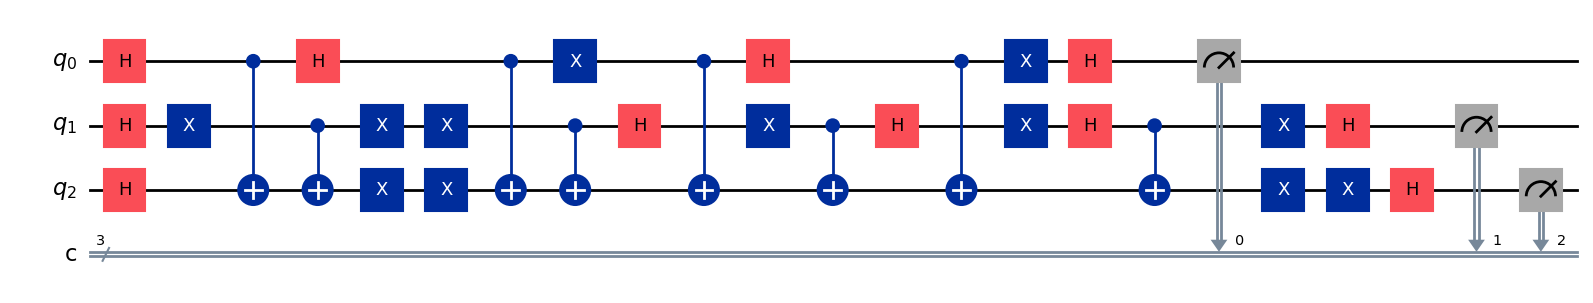

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 68] Best Fitness: 203.4650


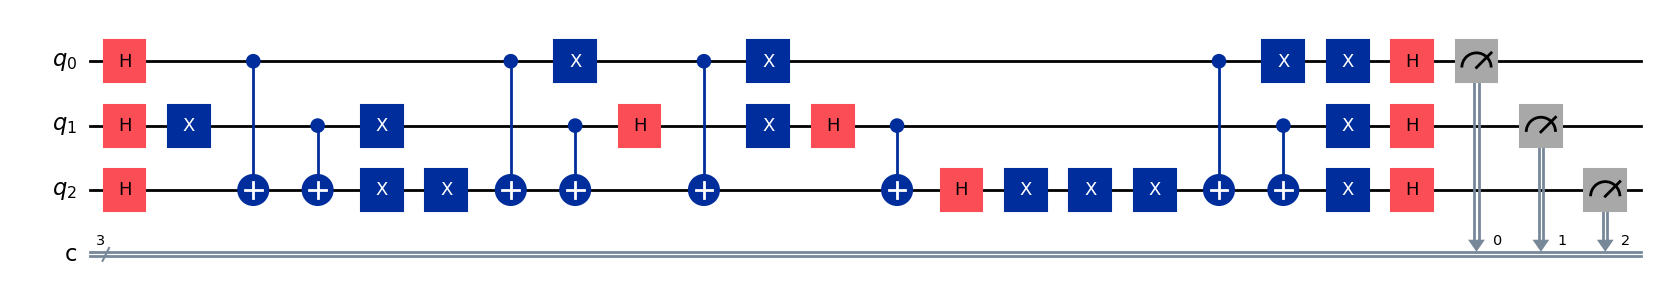

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 69] Best Fitness: 203.4650


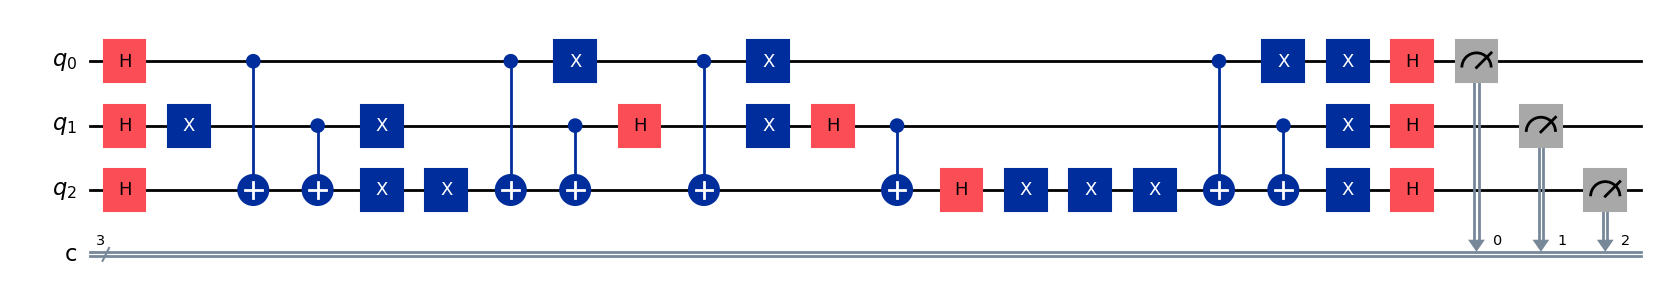

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 70] Best Fitness: 203.4650


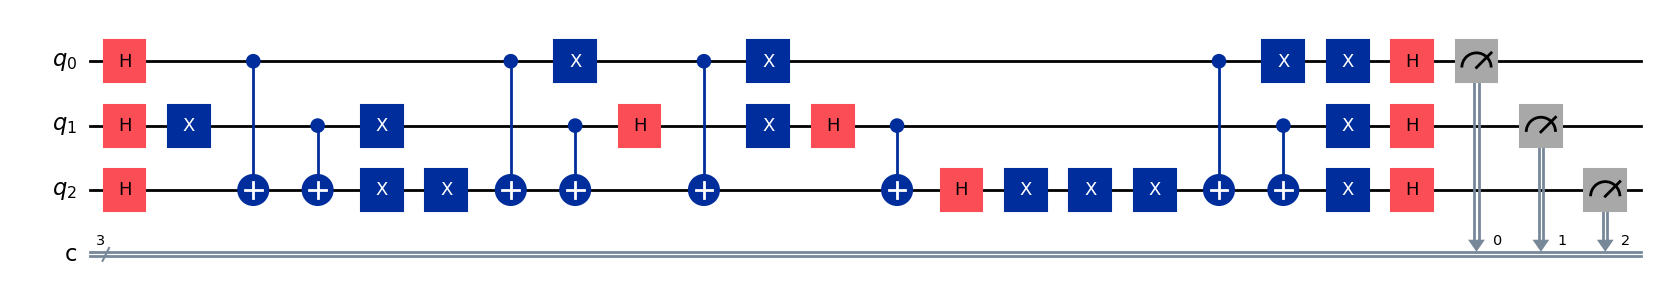

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 71] Best Fitness: 203.4650


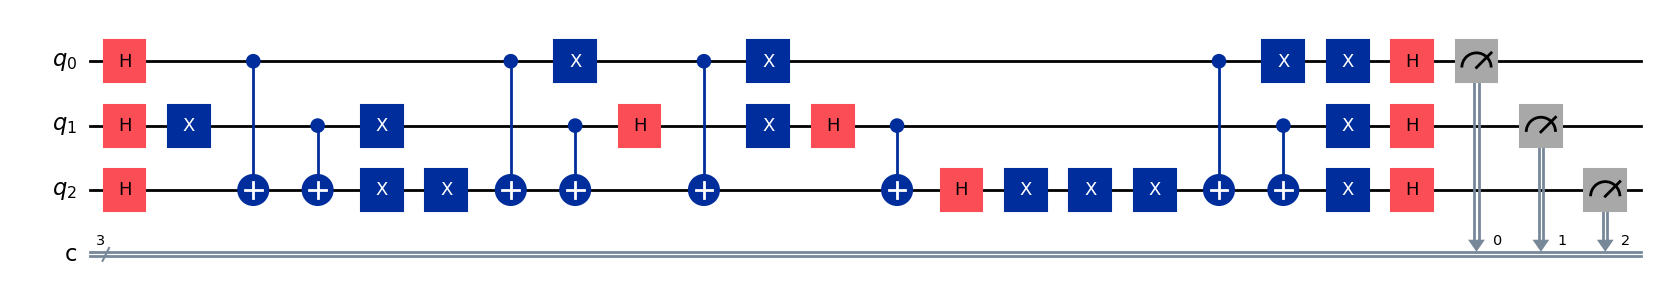

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 72] Best Fitness: 203.4650


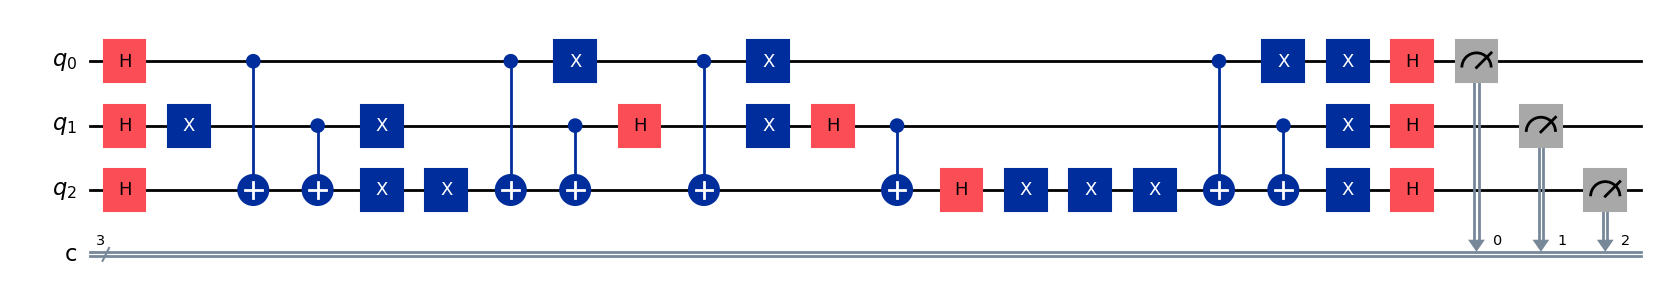

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 73] Best Fitness: 203.4650


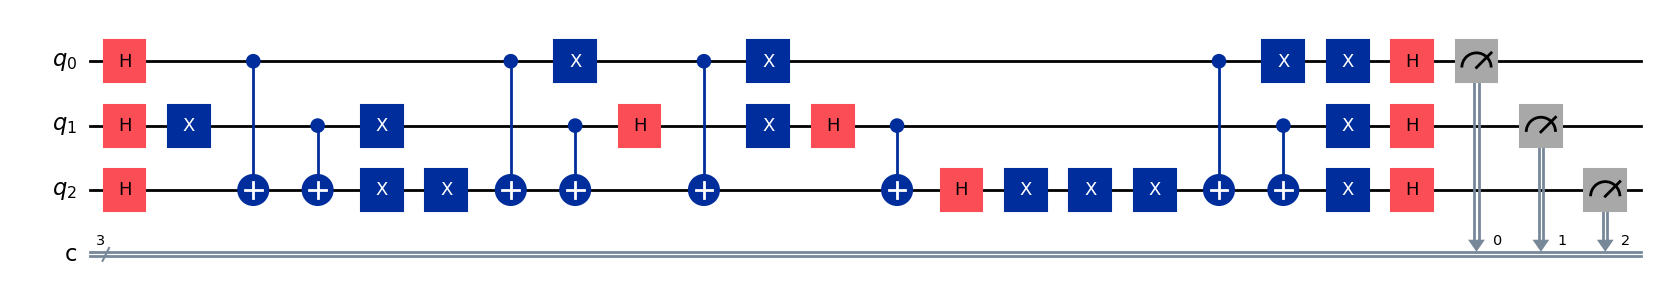

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 74] Best Fitness: 203.4650


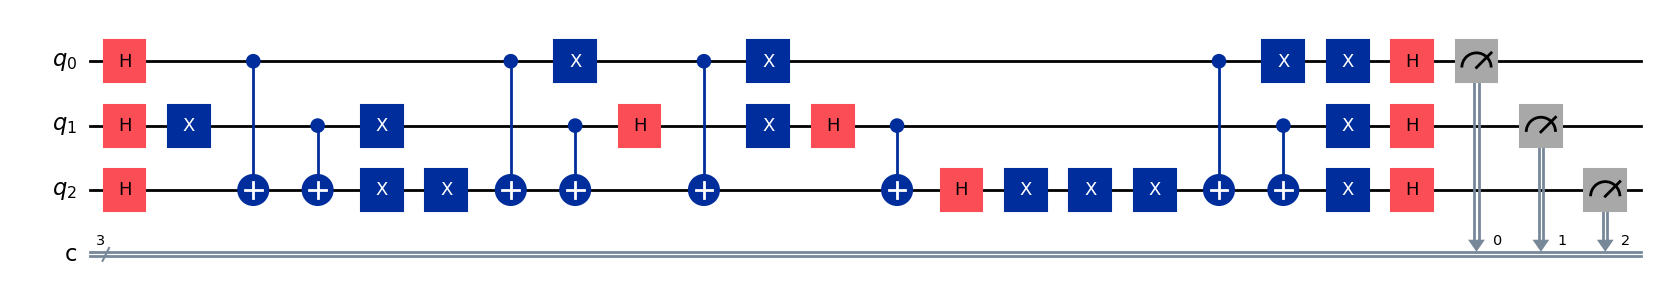

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 75] Best Fitness: 203.4650


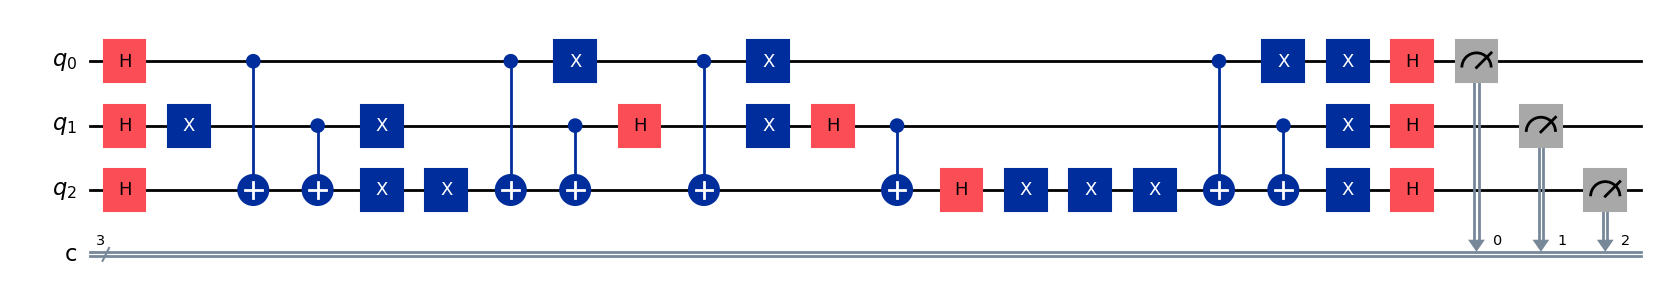

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 76] Best Fitness: 203.4650


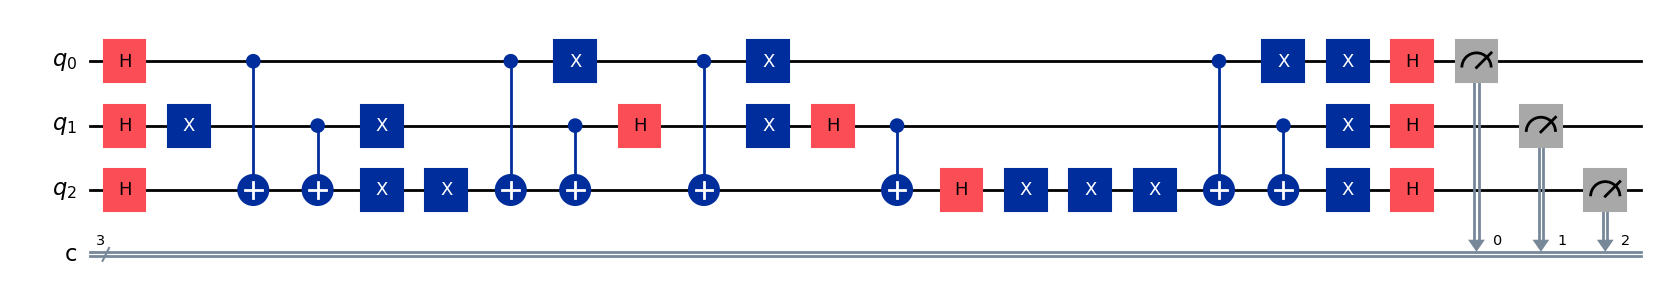

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 77] Best Fitness: 203.4650


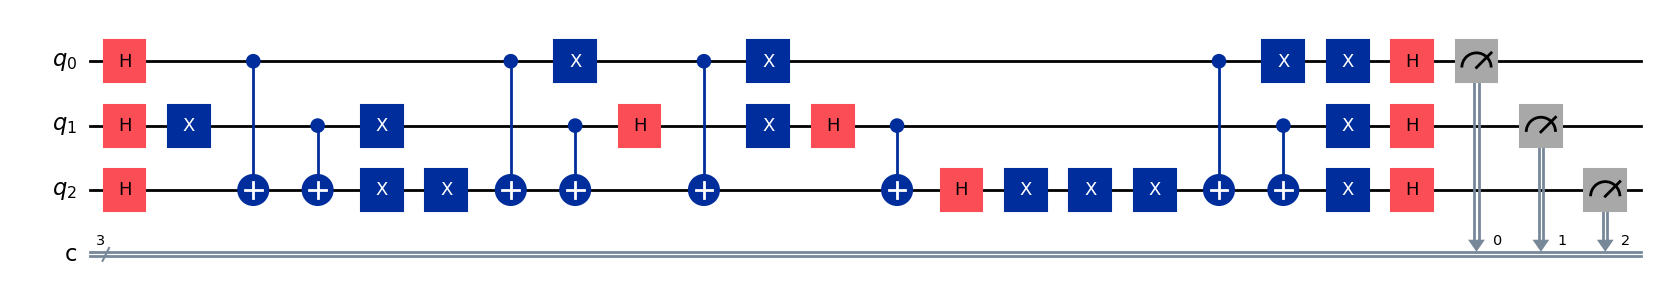

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 78] Best Fitness: 203.4650


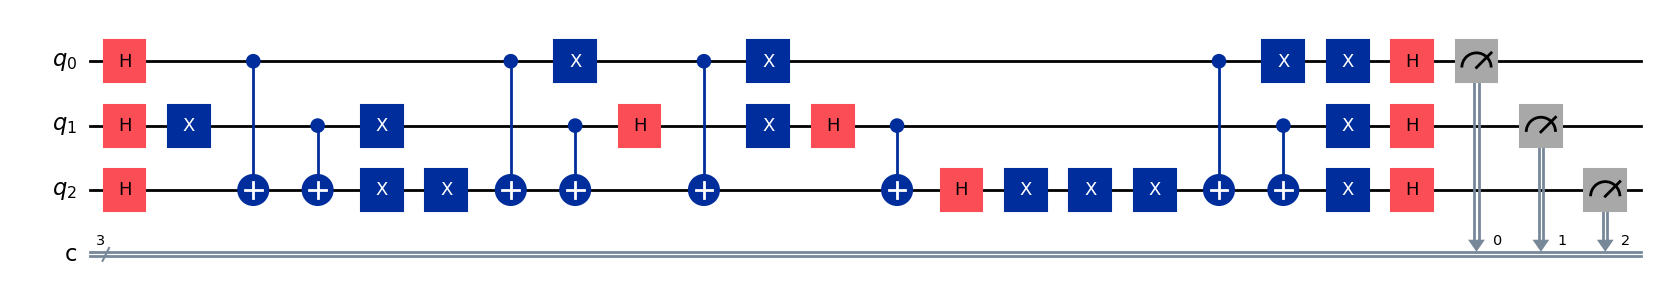

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 79] Best Fitness: 203.4650


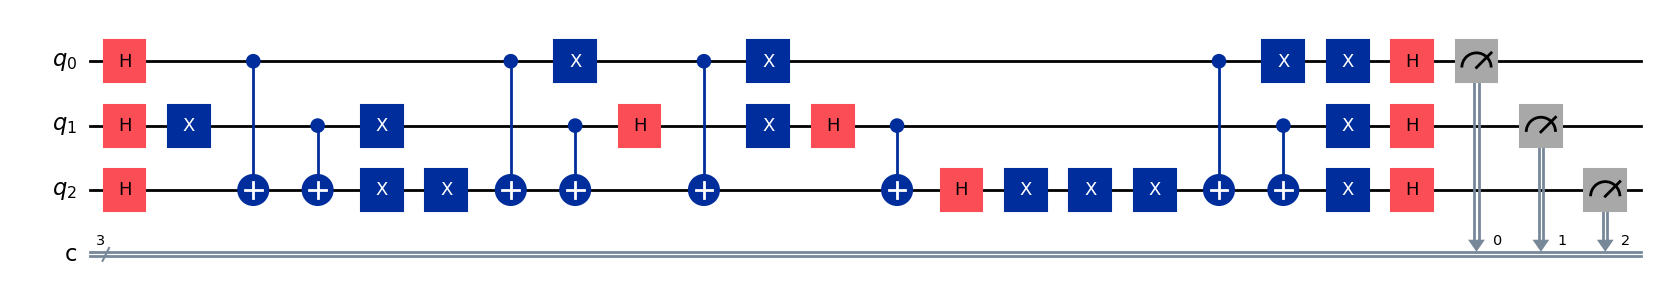

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 80] Best Fitness: 203.4650


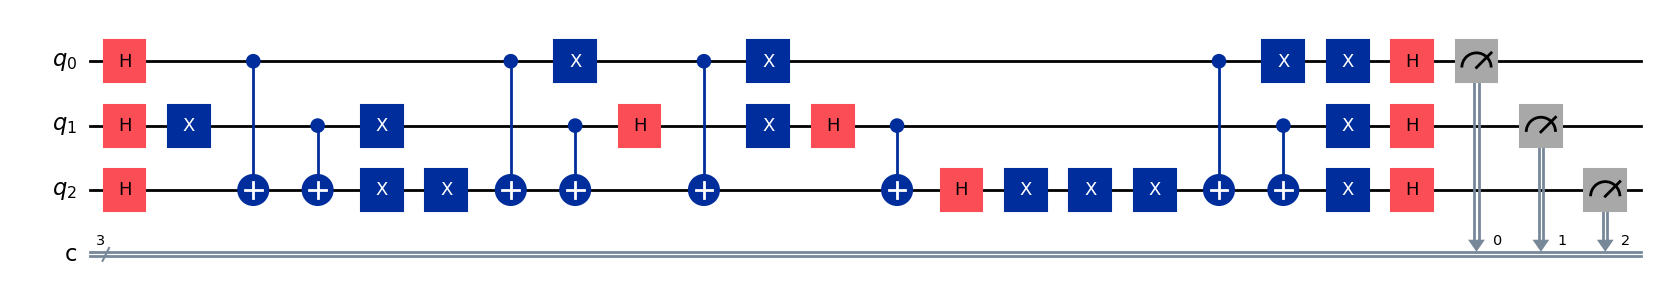

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 81] Best Fitness: 203.4650


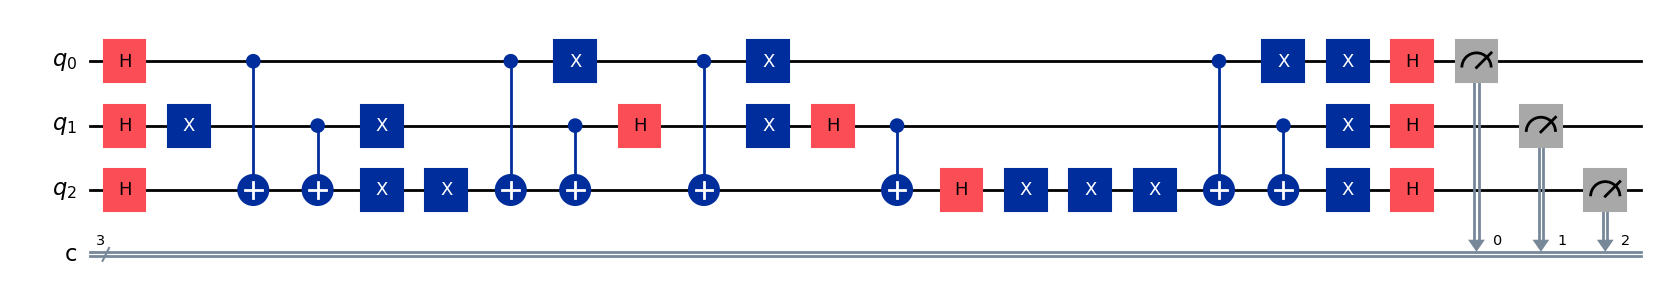

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 82] Best Fitness: 203.4650


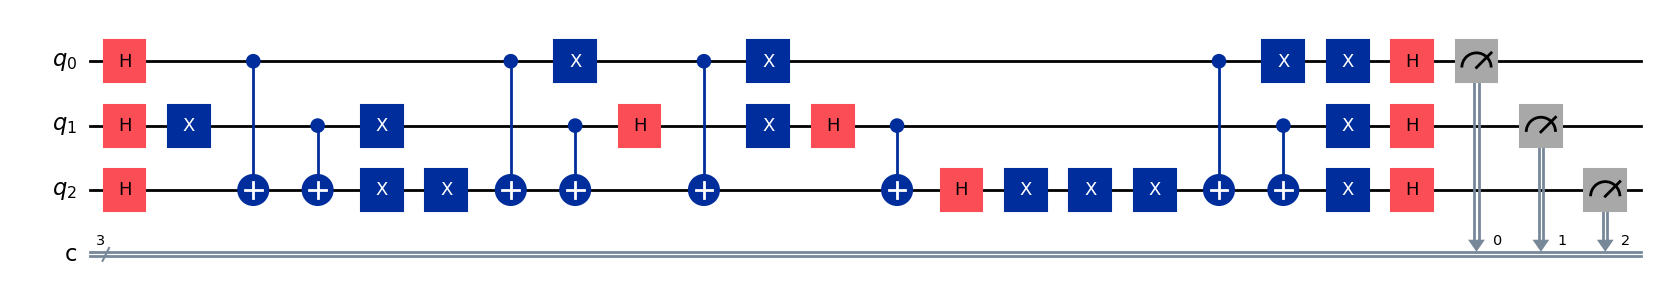

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 83] Best Fitness: 203.4650


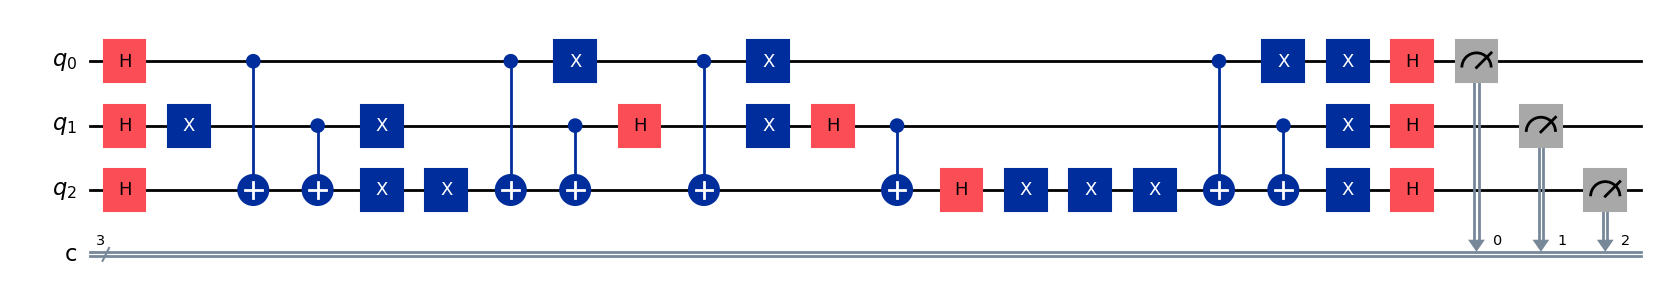

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 84] Best Fitness: 203.4650


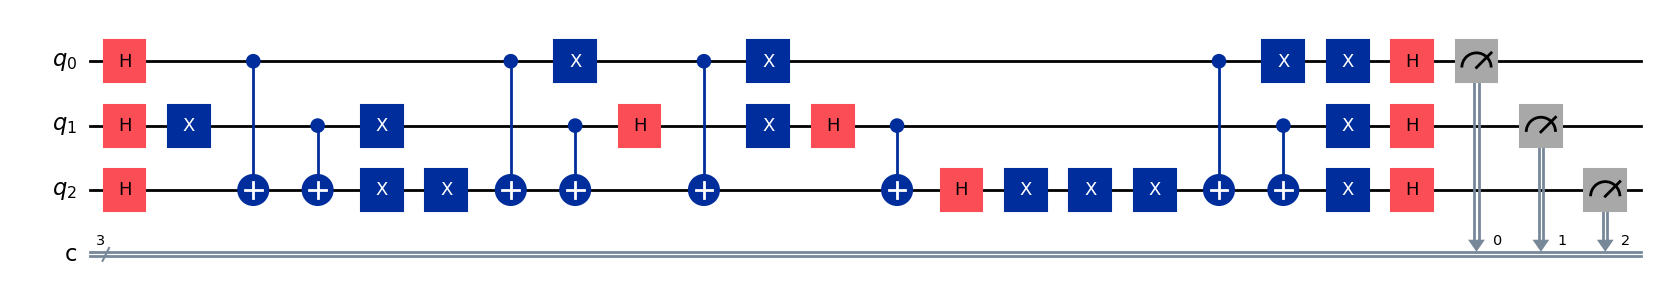

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 85] Best Fitness: 203.4650


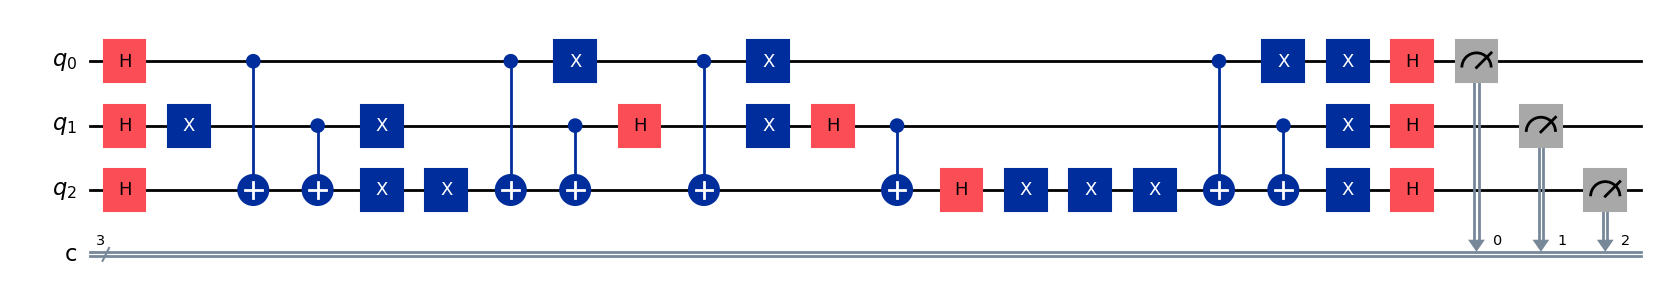

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 86] Best Fitness: 203.4650


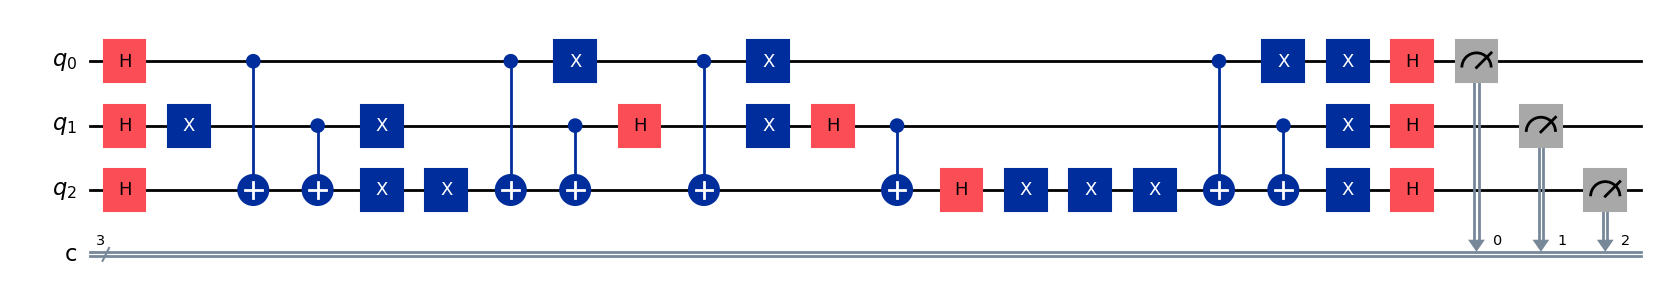

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 87] Best Fitness: 203.4650


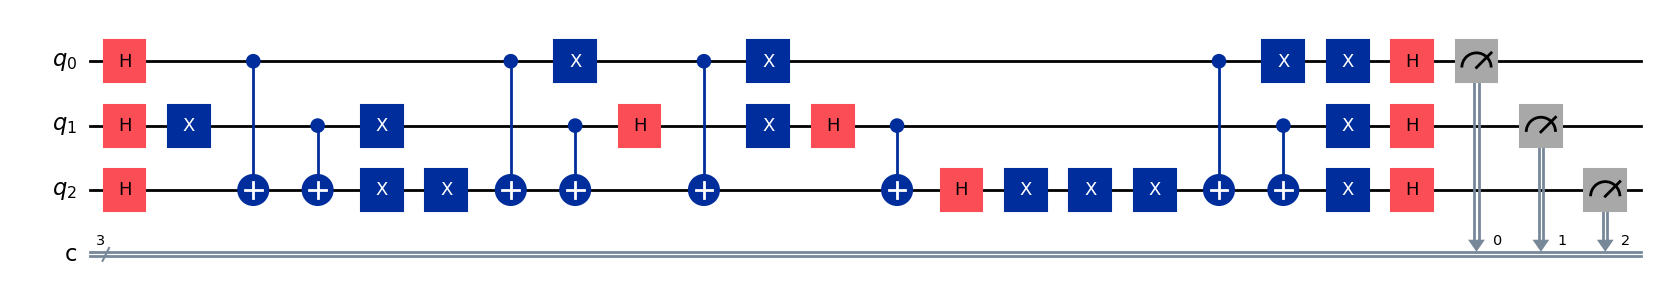

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 88] Best Fitness: 203.4650


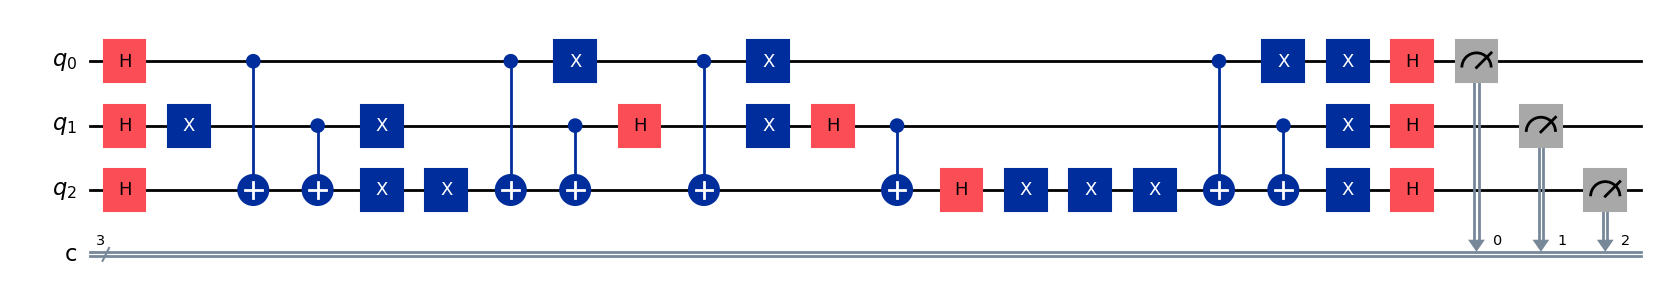

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 89] Best Fitness: 203.4650


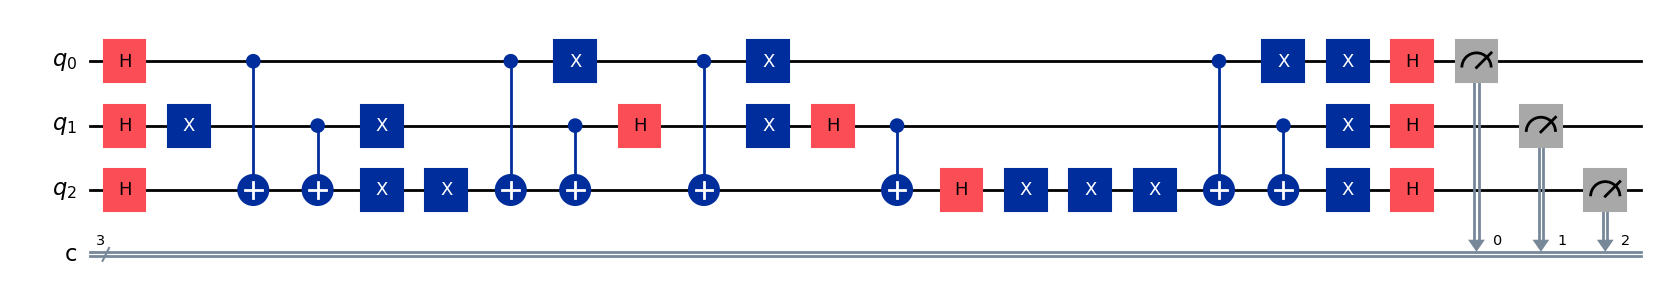

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 90] Best Fitness: 203.4650


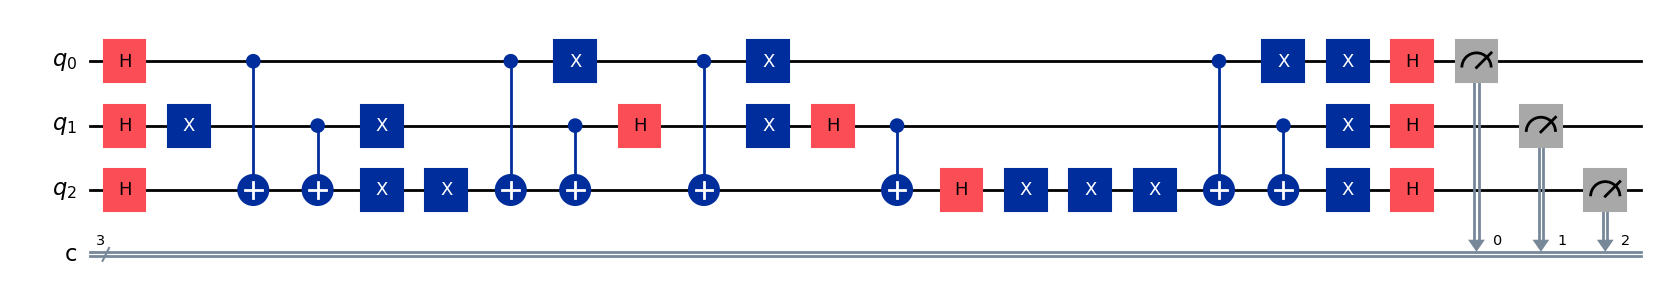

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 91] Best Fitness: 203.4650


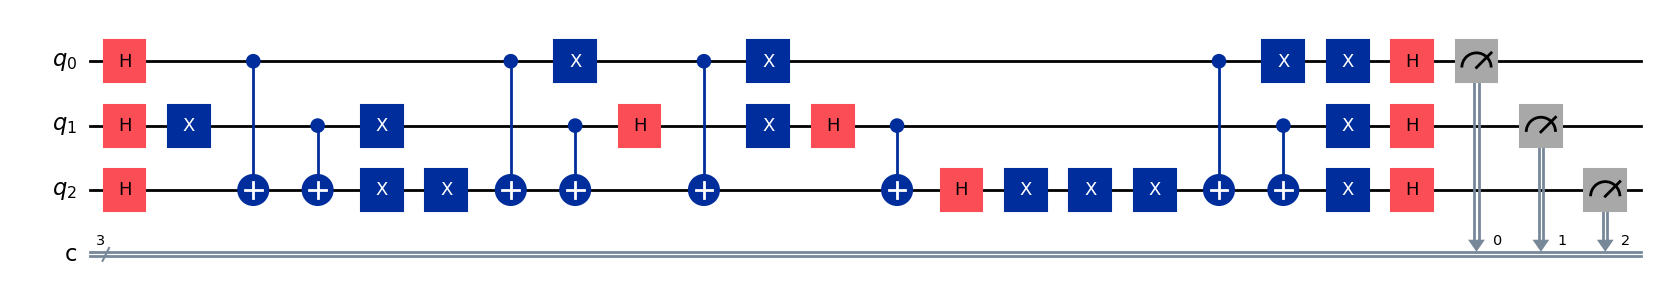

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 92] Best Fitness: 203.4650


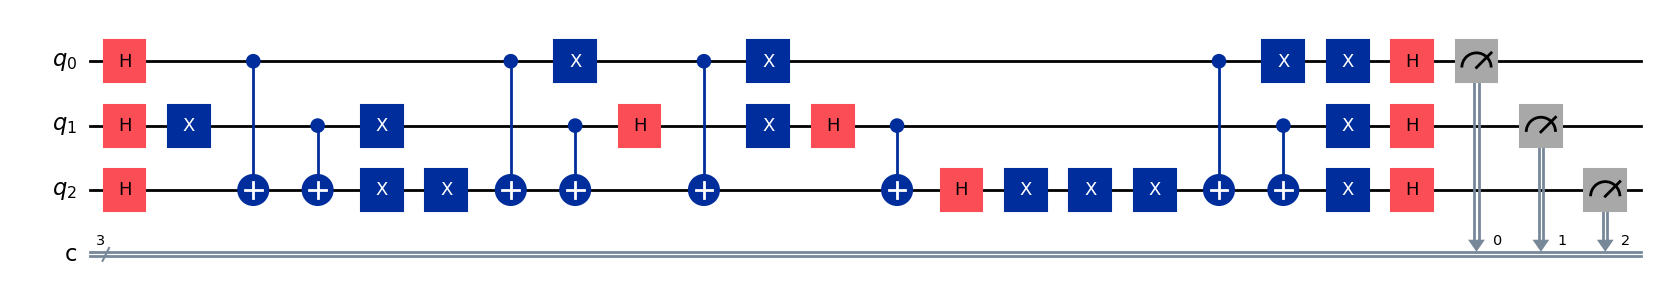

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.465),) , Number of invalids = 0

[Generation 93] Best Fitness: 203.4650


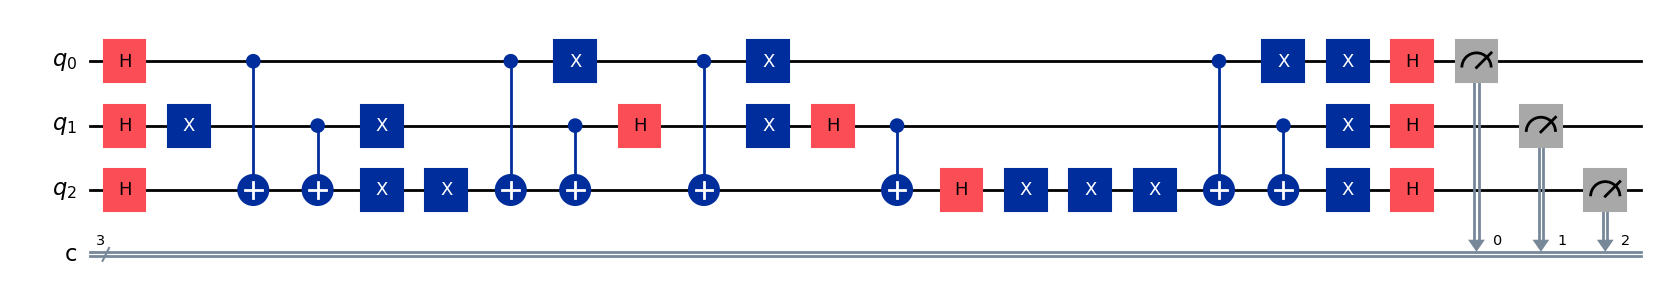

gen = 0 , Best fitness = (np.float64(203.465),)
gen = 1 , Best fitness = (np.float64(203.30875),) , Number of invalids = 0

[Generation 94] Best Fitness: 203.3088


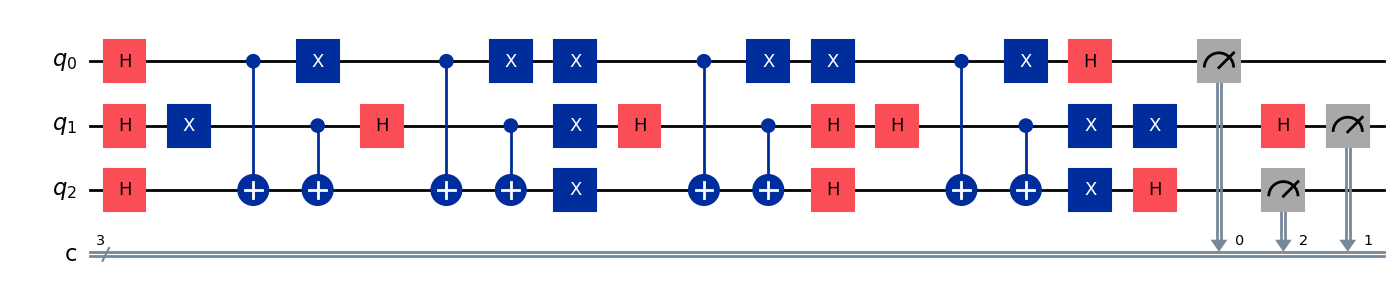

gen = 0 , Best fitness = (np.float64(203.30875),)
gen = 1 , Best fitness = (np.float64(203.30875),) , Number of invalids = 0

[Generation 95] Best Fitness: 203.3088


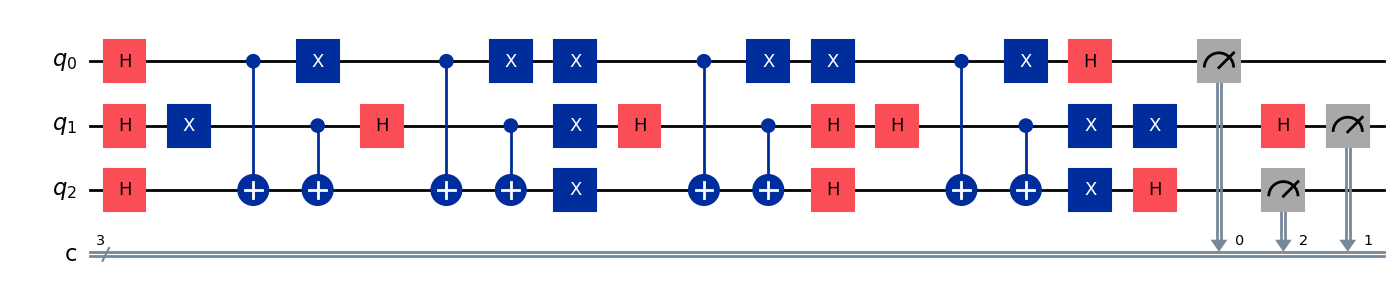

gen = 0 , Best fitness = (np.float64(203.30875),)
gen = 1 , Best fitness = (np.float64(203.30875),) , Number of invalids = 0

[Generation 96] Best Fitness: 203.3088


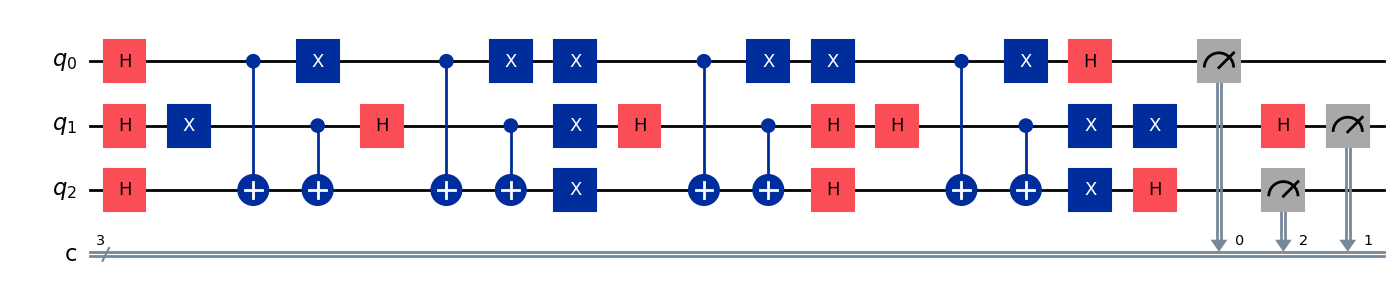

gen = 0 , Best fitness = (np.float64(203.30875),)
gen = 1 , Best fitness = (np.float64(203.30875),) , Number of invalids = 0

[Generation 97] Best Fitness: 203.3088


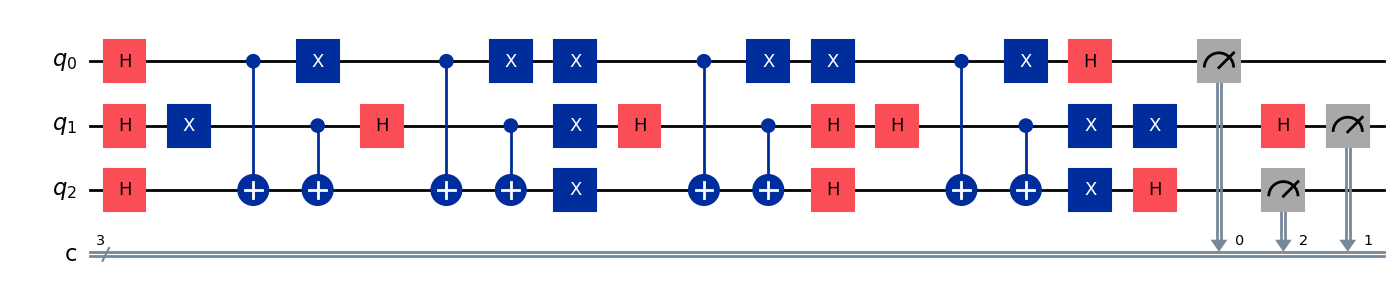

gen = 0 , Best fitness = (np.float64(203.30875),)
gen = 1 , Best fitness = (np.float64(203.30875),) , Number of invalids = 0

[Generation 98] Best Fitness: 203.3088


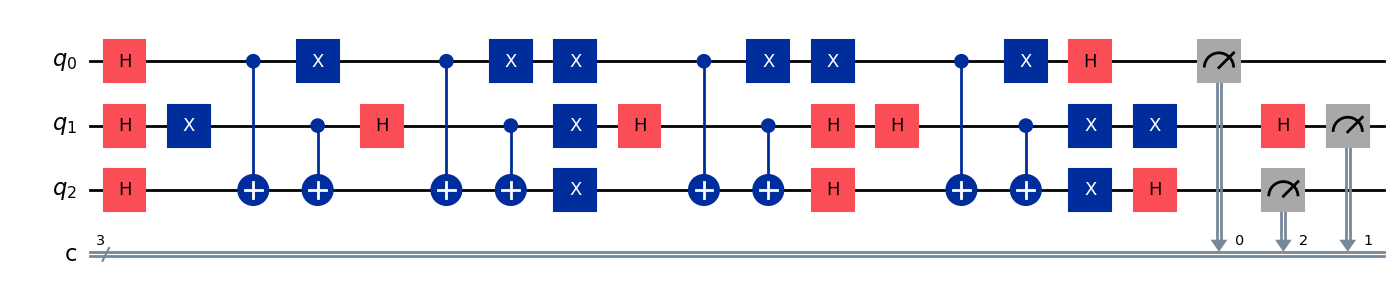

gen = 0 , Best fitness = (np.float64(203.30875),)
gen = 1 , Best fitness = (np.float64(203.30875),) , Number of invalids = 0

[Generation 99] Best Fitness: 203.3088


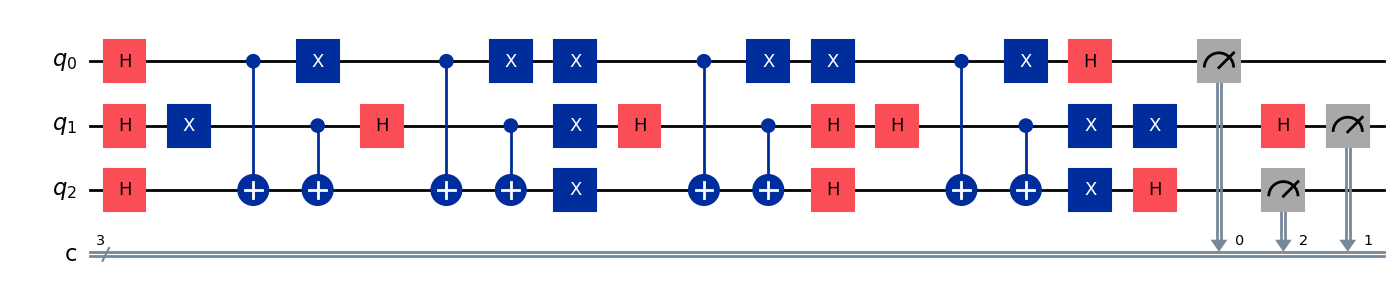

In [11]:
# Create an instance of the evaluator class
evaluator = CircuitEvaluator(shots=512, log_dir=LOG_DIR)

population = toolbox.populationCreator(
    pop_size=POPULATION_SIZE,
    bnf_grammar=BNF_GRAMMAR,
    min_init_depth=MIN_INIT_DEPTH,
    max_init_depth=MAX_INIT_DEPTH,
    codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION,
    genome_representation=GENOME_REPRESENTATION
)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# Prepare statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Lists to track trends over generations
generations_list = []
best_fitness_list = []
avg_gate_count_list = []

# Run the GE evolutionary algorithm with elitism
for gen in range(MAX_GENERATIONS):
    population, logbook = algorithms.ge_eaSimpleWithElitism(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=N_GEN,
        elite_size=ELITE_SIZE,
        bnf_grammar=BNF_GRAMMAR,
        codon_size=CODON_SIZE,
        max_tree_depth=MAX_TREE_DEPTH,
        codon_consumption=CODON_CONSUMPTION,
        report_items=REPORT_ITEMS,
        genome_representation=GENOME_REPRESENTATION,
        stats=stats,
        halloffame=hof,
        verbose=False
    )

    best_ind = tools.selBest(population, 1)[0]
    best_ind.generation = gen  # for logging

    # Evaluate the best individual to extract additional metrics
    best_phenotype = evaluator.decode_individual(best_ind)
    if best_phenotype is not None:
        fitness_val, logs = fitness_function(best_phenotype, log_states=True)
        best_fitness_list.append(fitness_val)
        # Calculate average gate count from logs (if available)
        if logs:
            avg_gate = np.mean([log["gate_count"] for log in logs])
        else:
            avg_gate = 0
        avg_gate_count_list.append(avg_gate)
        generations_list.append(gen)

    # Optional: visualize best circuit
    qc = evaluator.execute_circuit(best_phenotype)
    if qc:
        print(f"\n[Generation {gen}] Best Fitness: {best_ind.fitness.values[0]:.4f}")
        display(qc.draw("mpl"))
pool.close()
pool.join()


[HALL OF FAME]
Individual 1:
Genome: [102, 85, 307, 92, 65, 237, 22, 128, 187, 95, 189, 151, 92, 211, 344, 187, 147, 276, 307, 92, 211, 52, 187, 147, 22, 128, 187, 95, 189, 69, 147, 22, 128, 187, 95, 189, 78, 208, 136, 124, 159, 118, 314, 145, 151, 208, 136, 124, 159, 118, 314, 145, 3, 168, 239, 187, 92, 184, 207, 329, 166, 313, 146, 252, 167, 312, 180, 295, 29, 192, 370, 111, 300, 169, 98, 297, 133, 189, 162, 83, 163, 393, 325, 165, 338, 75, 366, 244, 51, 331, 139, 191, 107, 140, 311, 279, 113, 177, 171, 385, 123, 261, 33, 301, 340, 227, 361, 115, 47, 139, 80, 176, 297, 290, 286, 23, 285, 338, 320, 347, 310, 183, 264, 242, 173, 345, 101, 213, 393, 394, 233, 301, 301, 11, 308, 362, 159, 221, 316, 357, 376, 327, 68, 316, 357, 376, 327, 63, 238, 105, 47, 399, 198, 155, 308, 174, 103, 235, 78, 187, 10, 128, 349, 185, 322, 71, 338, 374, 359, 113, 203, 123, 76, 99, 277, 101, 343, 331, 52, 247, 77, 167, 339, 345, 140, 22, 393, 209, 301, 114, 308, 395, 335, 298, 381, 92, 184, 207, 329, 166, 

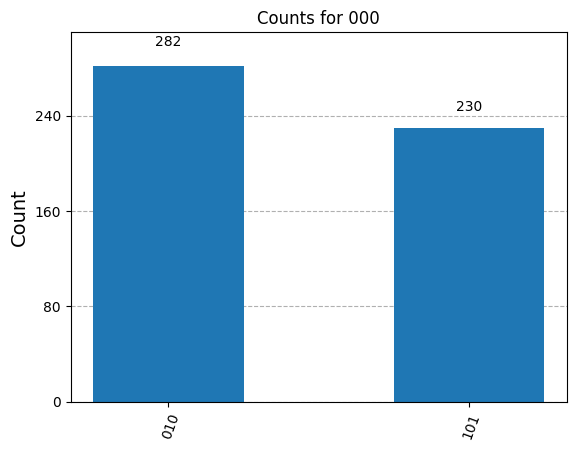

Marked State: 001
Oracle:
qc.x(0)
qc.x(1)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)
qc.x(1)

p(marked): 0.0000, error: 1.0000
Gate Count: 34


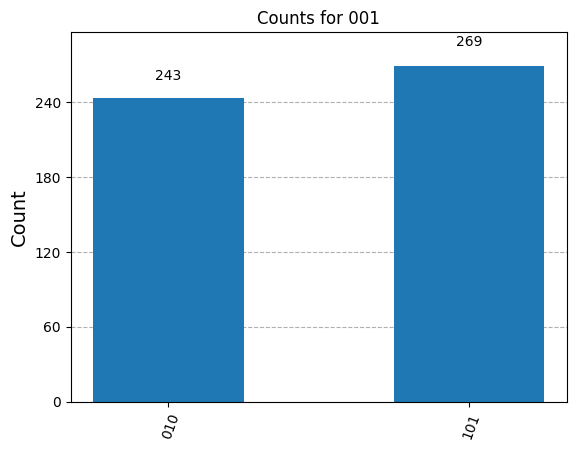

Marked State: 010
Oracle:
qc.x(0)
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)
qc.x(2)

p(marked): 0.4805, error: 0.5195
Gate Count: 34


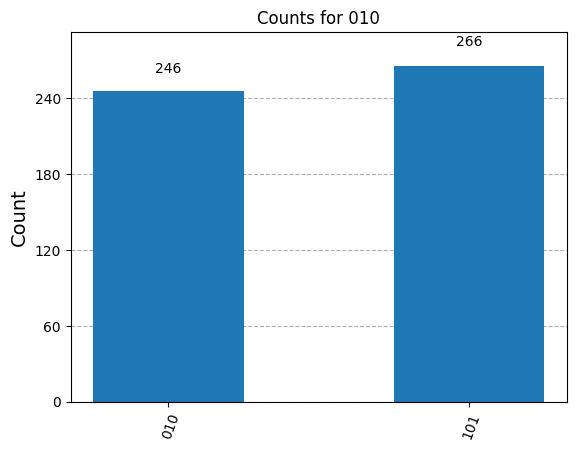

Marked State: 011
Oracle:
qc.x(0)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(0)

p(marked): 0.0000, error: 1.0000
Gate Count: 34


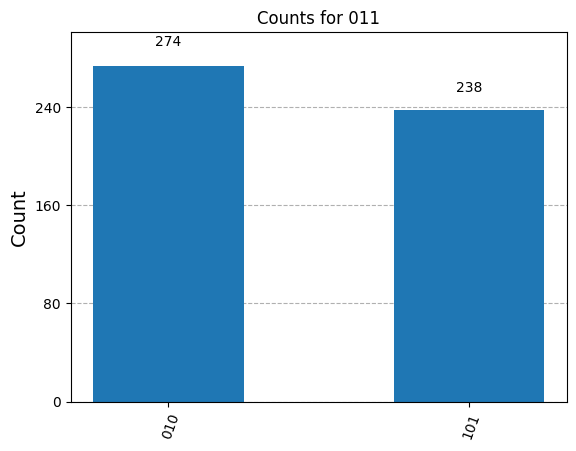

Marked State: 100
Oracle:
qc.x(1)
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(1)
qc.x(2)

p(marked): 0.0000, error: 1.0000
Gate Count: 34


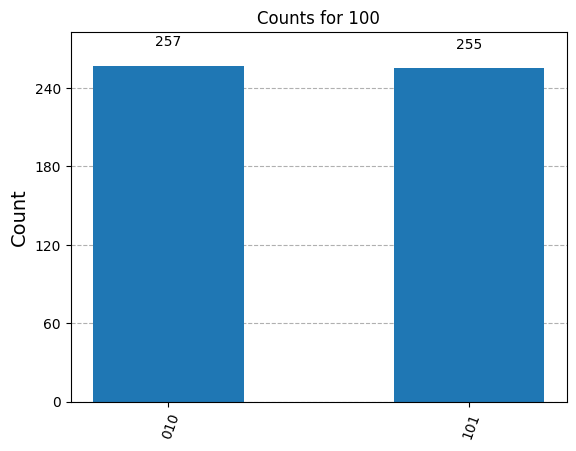

Marked State: 101
Oracle:
qc.x(1)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(1)

p(marked): 0.5234, error: 0.4766
Gate Count: 34


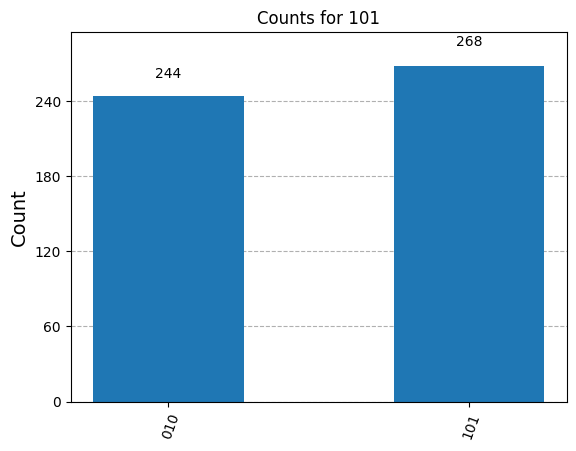

Marked State: 110
Oracle:
qc.x(2)
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)
qc.x(2)

p(marked): 0.0000, error: 1.0000
Gate Count: 34


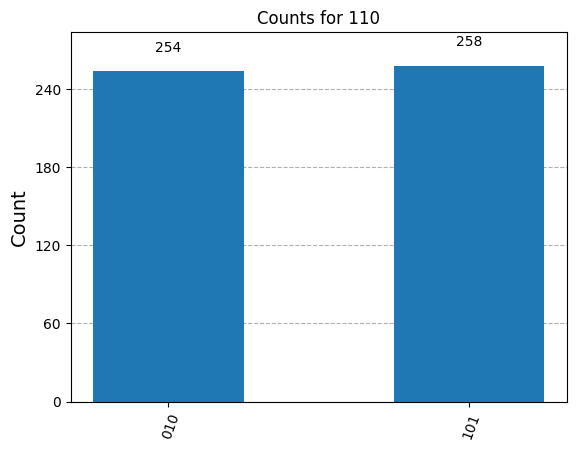

Marked State: 111
Oracle:
qc.h(2)
qc.mcx(list(range(2)), 2)
qc.h(2)

p(marked): 0.0000, error: 1.0000
Gate Count: 34


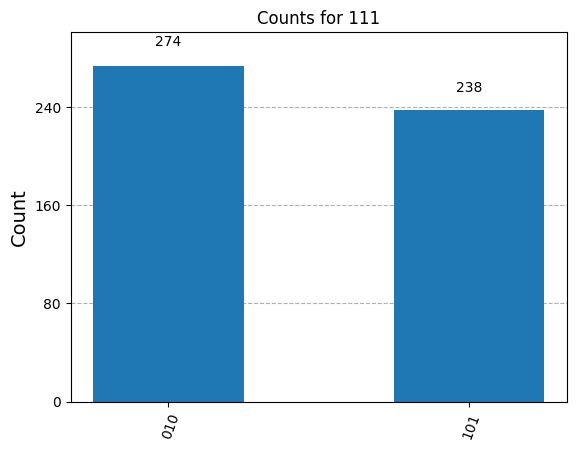

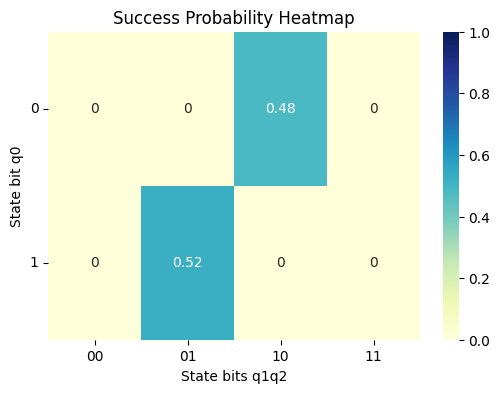

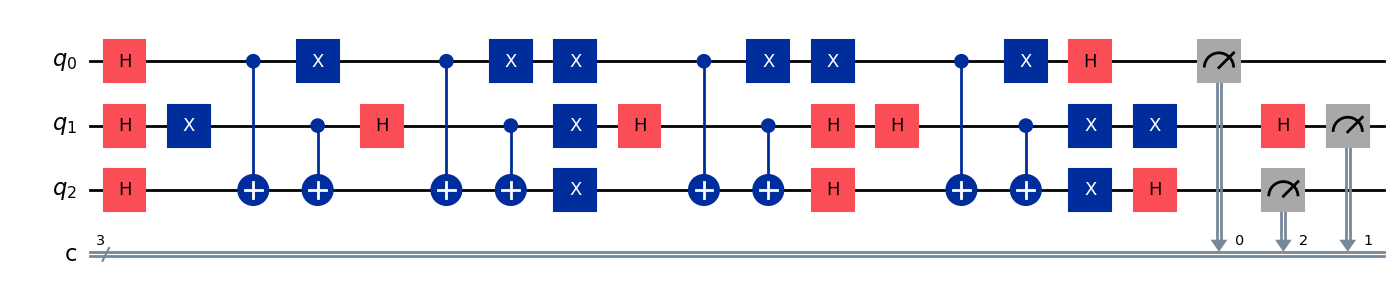


Best Individual's Fitness: 203.30875


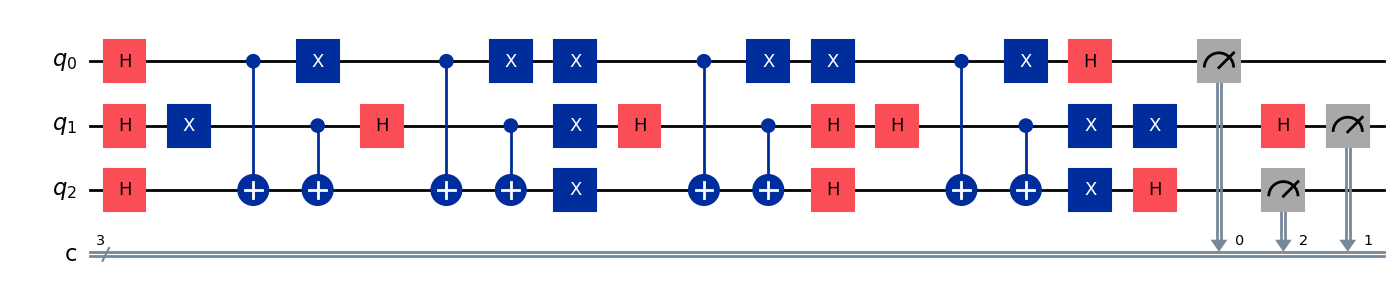

In [12]:
print("\n[HALL OF FAME]")
for i, hof_ind in enumerate(hof.items):
    print(f"Individual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

# Decode and display the best circuit from the Hall of Fame
best_ind = hof.items[0]
best_phenotype = evaluator.decode_individual(best_ind)
phenotype = evaluator.decode_individual(best_ind)
fitness, log_per_state = fitness_function(phenotype, log_states=True)

for log in log_per_state:
    print(f"Marked State: {log['state']}")
    print(f"Oracle:\n{log['oracle']}")
    print(f"p(marked): {log['p_marked']:.4f}, error: {log['error']:.4f}")
    print(f"Gate Count: {log['gate_count']}")
    display(plot_histogram(log["counts"], title=f"Counts for {log['state']}"))

# Visualize performance across all marked states
plot_success_heatmap(log_per_state)

# Convert the phenotype code string into an actual QuantumCircuit.
best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    display(best_circuit.draw("mpl"))  # Display the circuit diagram
else:
    print("The best individual could not be decoded into a valid circuit.")

print("\nBest Individual's Fitness:", best_ind.fitness.values[0])

# Convert and simulate the best circuit.
best_phenotype = evaluator.decode_individual(best_ind)
best_circuit = evaluator.execute_circuit(best_phenotype)
if best_circuit:
    display(best_circuit.draw('mpl'))
    simulator = QasmSimulator()
    compiled_circuit = transpile(best_circuit, simulator)
    result = simulator.run(compiled_circuit, shots=512).result()
    counts = result.get_counts()
    corrected_counts = {k[::-1]: v for k, v in counts.items()}  # Reverse bitstrings
    # Optionally, display histogram of measurement counts:
    # display(plot_histogram(corrected_counts, title="Measurement Counts for Best Individual"))
else:
    print("Best individual could not be decoded into a valid circuit.")

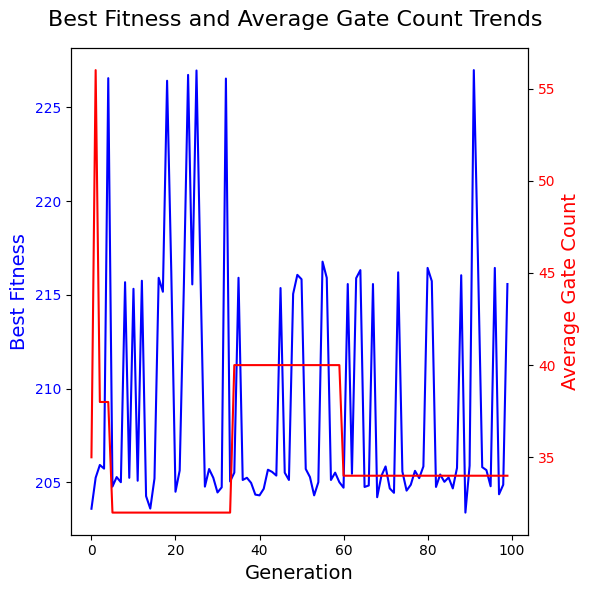

In [13]:
fig, ax1 = plt.subplots(figsize=(6, 6))

# Plot Best Fitness on the left y-axis
ax1.plot(generations_list, best_fitness_list, 'b-', label='Best Fitness')
ax1.set_xlabel('Generation', fontsize=14)
ax1.set_ylabel('Best Fitness', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the average gate count
ax2 = ax1.twinx()
ax2.plot(generations_list, avg_gate_count_list, 'r-', label='Avg Gate Count')
ax2.set_ylabel('Average Gate Count', color='r', fontsize=14)
ax2.tick_params(axis='y', labelcolor='r')

fig.suptitle('Best Fitness and Average Gate Count Trends', fontsize=16)
fig.tight_layout()
plt.show()